# This file works with ERUPTION and October 2013 Filament track information

In [70]:
from sunpy.net import hek
from sunpy.net import hek2vso
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib qt
import shapely
from shapely.wkt import dumps, loads
import numpy as np
import pandas as pd
from shapely.geometry.polygon import LinearRing, Polygon
from datetime import timedelta
import datetime
from sunpy.time import *
from dateutil.parser import parse
import matplotlib.cm as cm
import matplotlib as mpl
from operator import itemgetter
from itertools import groupby
import itertools
import operator
from datetime import timedelta
from matplotlib.dates import WeekdayLocator


In [2]:
client = hek.HEKClient()
h2v = hek2vso.H2VClient()
tstart = '2013/10/01 00:00:00'
tend = '2013/10/31 23:59:59'
event_type = 'ER'
eruptions = client.query(hek.attrs.Time(tstart,tend),hek.attrs.EventType(event_type))
vso_records = h2v.translate_and_query(eruptions[10])





In [3]:
def SetupSunPlotColor(eruptions, trackno, filament):
    plt.grid(True)
    plt.ylabel('ycoord (arcsec)',fontsize=18)
    plt.xlabel('xcoord (arcsec)',fontsize=18)
    plt.axis([-1500, 1500, -1500, 1500])
    cmap = plt.get_cmap('nipy_spectral')
    norm = mpl.colors.Normalize(vmin=0, vmax=280)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    scale= m.to_rgba(trackno)
    longitude = [elem["hpc_x"] for elem in eruptions]  #plotting only those eruptions that are contained in filaments 
    latitude = [elem["hpc_y"] for elem in eruptions]   #plotting only those eruptions that are contained in filaments
    for x,y in zip(longitude, latitude):
        fig=plt.scatter(x, y, color=next(colors),s=50)
    Circle1 = plt.Circle((0,0), radius=1000, linestyle='solid', linewidth=2, fill=False)
    fig1 = plt.gcf()
    fig1.gca().add_artist(Circle1)
    fig1.set_size_inches(10.5,10.5)
    ax = fig1.add_subplot(111)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Filament Eruptions and Tracks on the Sun, October 2013')
    plot_polygon=plt.Polygon(loads(filament).exterior,color=scale,linewidth=1,fill=None)
    fig1.gca().add_artist(plot_polygon) 



In [4]:
eruptions[0].keys()

[u'concept',
 u'frm_versionnumber',
 u'hrc_coord',
 u'hpc_bbox',
 u'area_atdiskcenter',
 u'event_mapurl',
 u'event_c1error',
 u'obs_dataprepurl',
 u'hgc_coord',
 u'frm_identifier',
 u'event_expires',
 u'intensmean',
 u'boundbox_c2ur',
 u'event_coordunit',
 u'gs_thumburl',
 u'obs_meanwavel',
 u'bound_ccnsteps',
 u'skel_curvature',
 u'hgs_coord',
 u'bound_chaincode',
 u'frm_daterun',
 u'intensmedian',
 u'bound_ccstartc1',
 u'frm_paramset',
 u'bound_ccstartc2',
 u'event_coord2',
 u'event_coord3',
 u'event_coord1',
 u'event_importance',
 u'kb_archivdate',
 u'event_title',
 u'hrc_r',
 u'hgc_bbox',
 u'skel_chaincode',
 u'intenstotal',
 u'hrc_a',
 u'area_atdiskcenteruncert',
 u'event_probability',
 u'gs_movieurl',
 u'event_description',
 u'eventtype',
 u'ar_polarity',
 u'obs_channelid',
 u'ar_mcintoshcls',
 u'frm_institute',
 u'frm_contact',
 u'ar_noaaclass',
 u'boundbox_c1ur',
 u'hgs_boundcc',
 u'boundbox_c2ll',
 u'area_unit',
 u'area_raw',
 u'intensskew',
 u'hpc_coord',
 u'frm_name',
 u'obs

In [5]:
times=[elem["event_starttime"] for elem in eruptions] 
result=[]
indices=[]
### the following loop will remove identical eruptions that have been recorded at different wavelengths by sorting with time
for element in times:
    if element not in result:
        indices.append((times.index(element)))
        result.append(element)
filtered=[eruptions[i] for i in indices]
print len(filtered)

540


# reads in the correct file, drops those tracks with less than three elements

In [6]:
fi_tracked = pd.read_csv('FIDustinTracked_2013_10.txt',delimiter='\t')
fi_tracked.head()
tracks=fi_tracked['Track No.']
good_tracks = fi_tracked.groupby('Track No.').filter(lambda x: len(x['Track No.']) >= 3, dropna=False) 



# Loops through both eruption data and track data. Checks if any track polygons contain an eruption point. Then checks if these eruptions can be found in +/- 12 hours of the polygon. 

In [7]:
margin = datetime.timedelta(hours=12)             
FT_time = good_tracks['HEK_time']    #Finds the time stamps for all the filaments
FE_time = [elem["event_starttime"] for elem in filtered] #Finds the time stamps for all the eruptions
FT_poly = good_tracks['HPC_BB_Poly']    #Finds the polygon coordinates for the good_tracks
FE_coords = [elem["hpc_coord"] for elem in filtered] #Finds the point coordinates for the filtered eruptions 
contained=[]    ####This will be a helpful list for finding which tracks have eruptions contained inthem 
big_track=[]
loopnumb=[]    #to keep track of the eruption number 
for j in range(0, len(FE_coords)):    #looks at all possible eruptions 
    FET=(parse_time(FE_time[j])) 
    FE_point_obj = loads(FE_coords[j]) #creates a shapely point object
    for i in range(0, len(FT_poly)):  #looks at all possible tracks 
        if pd.isnull(FT_poly[i]):   #skips over tracks of less than 3 elements 
            pass
        else:   
            FLT=parse(FT_time[i]) 
            FT_poly_obj = loads(FT_poly[i])   #creates polygon object from track
            if FT_poly_obj.contains(FE_point_obj) and FET-margin <= FLT <= FET + margin: #checks if point is contained in polygon
                contained.append(good_tracks['Track No.'][i])   #finds the track number of these tracks 
                loopnumb.append(j)
                print FE_time[j]
                print "This means that the eruption point is contained in the filament polygon"
                print j,i
            ###### to find tracks with a big area 
            if FT_poly_obj.area > 3500:
                big_track.append(good_tracks['Track No.'][i])
erup=[indices[i] for i in loopnumb]   #getting the eruption index from a list of possible indices
filtered2=[eruptions[i] for i in erup]   #eruption data that correspond to being contained in a filament

2013-10-11T12:00:00
This means that the eruption point is contained in the filament polygon
70 229
2013-10-26T07:40:00
This means that the eruption point is contained in the filament polygon
351 563


In [8]:
print contained
good_polygons=[] #Trying to find polygon data for the filaments that contained eruptions and at a good time 
for i in range(len(good_tracks)): #iterating through the whole list of tracks 
    if good_tracks['Track No.'][i] in contained:  #if the track number is in the lists created previously 
         good_polygons.append((good_tracks['Track No.'][i],good_tracks['HPC_BB_Poly'][i]))#append the polygon data to good polygons

[102.0, 218.0]


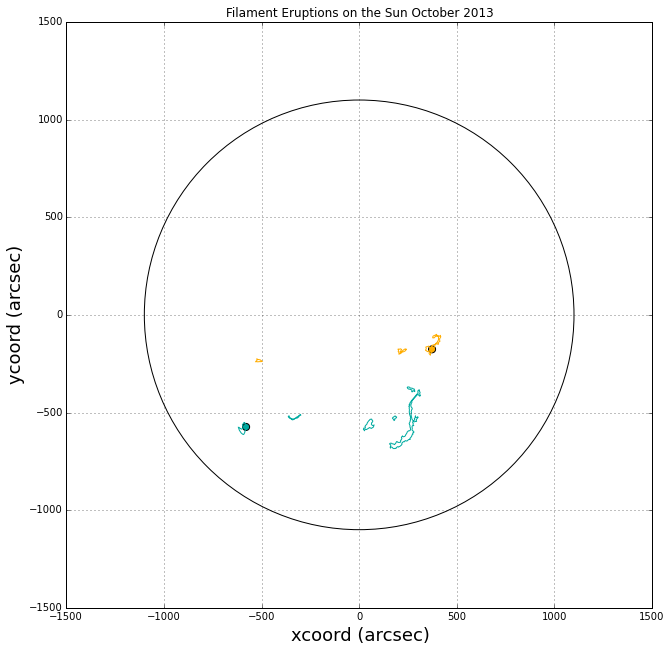

In [9]:
colorscale=[]
norm = mpl.colors.Normalize(vmin=0, vmax=280)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
for item in contained: #plotting those filaments that have eruptions contained within them
    scale1= m.to_rgba(item) 
    colorscale.append(scale1)

####plots eruptions/sun 
plt.grid(True)
plt.ylabel('ycoord (arcsec)',fontsize=18)
plt.xlabel('xcoord (arcsec)',fontsize=18)
plt.axis([-1500, 1500, -1500, 1500])
longitude = [elem["hpc_x"]for elem in filtered2]
latitude = [elem["hpc_y"] for elem in filtered2]
fig=plt.scatter(longitude,latitude,c= colorscale,s=50)
Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
plt.gcf().gca().add_artist(Sun)
plt.title('Filament Eruptions on the Sun October 2013')
fig1 = plt.gcf()
fig1.set_size_inches(10.5,10.5)
ax = fig1.add_subplot(111)
ax.set_aspect('equal') 

####plots filament tracks 
for poly in good_polygons: 
    scale=m.to_rgba(poly[0])
    plot_polygon=plt.Polygon(loads(poly[1]).exterior,color=scale,linewidth=1,fill=None)
    fig1.gca().add_artist(plot_polygon)
plt.show()

[102.0, 218.0]
230.0 2013-10-24 18:08:06
230.0 2013-10-25 17:47:37
230.0 2013-10-26 17:52:06
230.0 2013-10-27 07:07:15


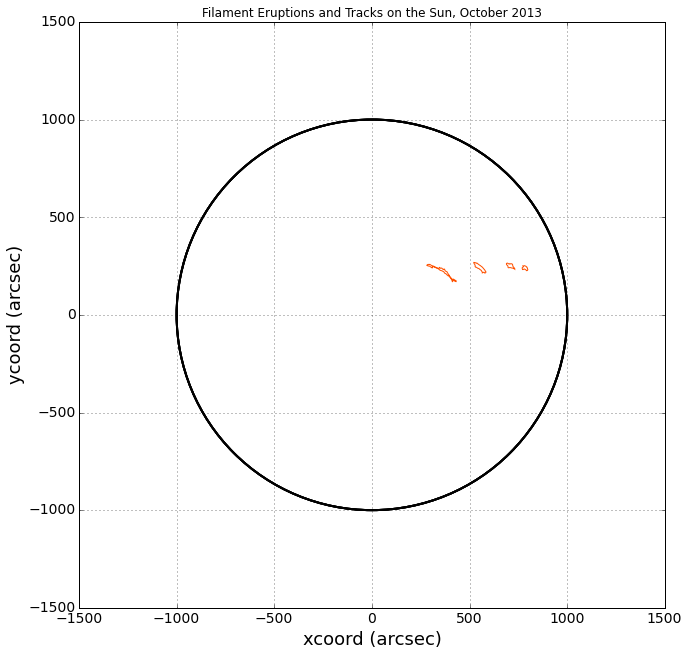

In [10]:
noerup=[]
check_track=[230.0]
checking=sorted(contained)
print checking
check_poly=[]
for i in range(len(good_tracks)): #iterating through the whole list of tracks 
    #if good_tracks['Track No.'][i] in intersected and good_tracks['Track No.'][i] in okay_filaments:   #if the track number is in the list created previously 
    if good_tracks['Track No.'][i] in check_track: 
            check_poly.append((good_tracks['Track No.'][i],good_tracks['HPC_BB_Poly'][i])) #append the polygon data to good polygons
            print good_tracks['Track No.'][i],good_tracks['HEK_time'][i]
            
            
for poly in check_poly: #plotting those filaments that have eruptions contained within them
    SetupSunPlotColor(noerup, poly[0], poly[1]) #filament eruption coordinates, track number, track polygon coordinates

does_track_erup=[]



In [11]:
margin = datetime.timedelta(hours=12)             
FT_time = good_tracks['HEK_time']    #Finds the time stamps for all the filaments
FE_time = [elem["event_starttime"] for elem in filtered] #Finds the time stamps for all the eruptions
FT_poly = good_tracks['HPC_BB_Poly'] 
FE_box = [elem["hpc_bbox"] for elem in filtered] 
FE_coords = [elem["hpc_coord"] for elem in filtered]
FT_coords=good_tracks['HPC_Center']
intersected=[] #the tracks that intersect with eruption boxes
event=[]  #eruption point 
manypoly=[] #center point of filament
erupno=[]   #eruption's number 
practice=[]
time_erup=[]
time_fil=[]
########## to only plot certain eruptions
for j in range(0, len(FE_box)):    #looks at all possible eruptions 
    FET=(parse_time(FE_time[j]))
    FE_box_obj = loads(FE_box[j]) #creates a shapely box object object
    FE_point_obj=loads(FE_coords[j])
    for i in range(1, len(FT_poly)):  #looks at all possible tracks 
        if pd.isnull(FT_poly[i]):   #skips over tracks of less than 3 elements 
            pass
        else:  
            FLT=parse(FT_time[i])
            FT_poly_obj = loads(FT_poly[i])   #creates polygon object from track
            FT_center=loads(good_tracks['HPC_Center'][i])
            #if FT_poly_obj.intersects(FE_box_obj) and FET-margin <= FLT <= FET + margin: #checks if box intersects with polygon
            if FT_center.distance(FE_point_obj) < 200 and FET-margin <= FLT <= FET + margin:
                intersected.append(good_tracks['Track No.'][i])   #finds the track number of these tracks 
                manypoly.append(loads(good_tracks['HPC_Center'][i]))  #grabs the center point coords of the filament 
                event.append(FE_point_obj)      #grabs the eruption point 
                erupno.append(j)
                FT_center=loads(good_tracks['HPC_Center'][i])
                time_erup.append(FET)
                time_fil.append(FLT)
                #print FT_center
multi=zip(intersected, event, manypoly, erupno, time_erup, time_fil)


In [11]:
print len(intersected)

354


In [66]:
dist=[]  ###will be a list of distances between the eruptions and center of the filaments 
final_erup=[]   #eruption's number
practice=[]
time_diff=[]
for item in multi:
     dist.append(item[1].distance(item[2]))
     time0= abs(item[4]-item[5])
     time_diff.append(time0.seconds)
multi2=zip(intersected, event, dist, erupno, time_erup, time_diff) #this is a new tuple for (track no, eruption coord, distance to filament, eruption number)

##the following is Nicole's code using pandas
multi3=zip(intersected, event, dist, erupno, time_erup) #This is what you did
test = pd.DataFrame(multi3) #Turn multi3 into a pandas dataframe
columns=['Track No.','Eruption Coord','Distance to filament','Eruption No.', 'Eruption Time'] #Name the columns so they are easier to deal with
test.columns=columns
idx = test.groupby(['Track No.'])['Distance to filament'].transform(min) == test['Distance to filament']
only_min=test[idx]
only_min = only_min.sort('Track No.')
close=[]   #those tracks closest to the eruptions 
corresponding=[] ### just to know which tracks correspond to which eruption 
print only_min
for index, item in only_min.iterrows():
    if item[2] < 150:
        close.append(item[0])   #for the tracks 
        final_erup.append(item[3])   #for the eruptions 
        corresponding.append((item[0], item[3]))   # to see which tracks correspond to which eruptions
        practice.append((item[4], item[0]))
print corresponding    
    
erupbox_with_track=[indices[i] for i in final_erup]
filtered3=[eruptions[i] for i in erupbox_with_track]

#next line makes a list of finding the minimum values based on distance, grouped by eruption number (1 distance per eruption)
#min_erup = list(min(v, key=operator.itemgetter(2)) for k, v in itertools.groupby(multi2, operator.itemgetter(3)))
#next line makes a list of finding the minimum values based on distance, grouped by track number (1 distance per track)
#min_track= list(min(r, key=operator.itemgetter(2)) for k,r in itertools.groupby(min_erup, operator.itemgetter(0)))
#min_track= list(max(r, key=operator.itemgetter(5)) for k,r in itertools.groupby(min_erup, operator.itemgetter(1)))
#print len(min_erup), len(min_track)
#close=[]   #those tracks closest to the eruptions 
#corresponding=[] ### just to know which tracks correspond to which eruption 
#for item in min_track:
    #if item[2] < 150:
        #close.append(item[0])   #for the tracks 
        #final_erup.append(item[3])   #for the eruptions 
        #corresponding.append((item[0], item[3]))   # to see which tracks correspond to which eruptions
        #practice.append((item[4], item[0]))
        #what.append((item[0], item[2], item[3]))
#erupbox_with_track=[indices[i] for i in final_erup]
#filtered3=[eruptions[i] for i in erupbox_with_track]


     Track No.                     Eruption Coord  Distance to filament  \
2           16                   POINT (164 -304)             95.858493   
1           17                  POINT (896.4 450)            124.731190   
6           20                  POINT (-222 10.8)            144.496037   
5           32                 POINT (231.6 -234)             56.072073   
0           43             POINT (-1006.8 -106.8)            139.097524   
57          54                  POINT (915.6 354)             88.489240   
12          57               POINT (838.8 -370.8)             71.492399   
10          61                 POINT (-234 -46.8)             37.137567   
7           70              POINT (-865.2 -603.6)            145.655517   
36          72     POINT (75.59999999999999 -666)            185.183566   
11          76                 POINT (-234 -46.8)            126.012556   
41          77              POINT (-190.8 -332.4)             17.125888   
13          83           

In [15]:
okay_polygons=[] #Trying to find polygon data for the filaments that intersect with eruption box
for i in range(len(good_tracks)): #iterating through the whole list of tracks 
    #if good_tracks['Track No.'][i] in intersected and good_tracks['Track No.'][i] in okay_filaments:   #if the track number is in the list created previously 
    if good_tracks['Track No.'][i] in close: 
            okay_polygons.append((good_tracks['Track No.'][i],good_tracks['HPC_BB_Poly'][i])) #append the polygon data to good polygons

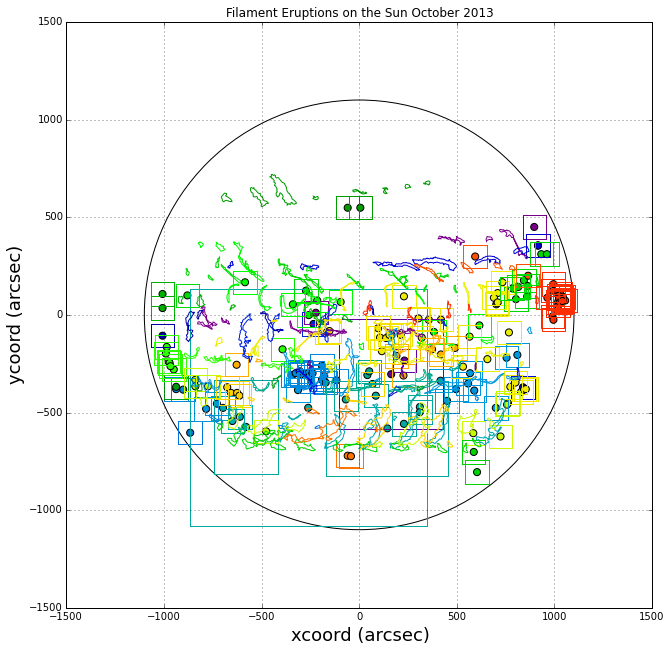

In [16]:
#Basic plot 


####makes a colorscale for eruptions 
colorscale2=[]
norm = mpl.colors.Normalize(vmin=0, vmax=280)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
for item in close: #plotting those filaments that have eruptions contained within them
    scaleR= m.to_rgba(item) 
    colorscale2.append(scaleR)
    
####plots eruptions/sun
plt.grid(True)
plt.ylabel('ycoord (arcsec)',fontsize=18)
plt.xlabel('xcoord (arcsec)',fontsize=18)
plt.axis([-1500, 1500, -1500, 1500])
longitude = [elem["hpc_x"]for elem in filtered3]
latitude = [elem["hpc_y"] for elem in filtered3]
fig=plt.scatter(longitude,latitude,c= colorscale2,s=50)
Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
plt.gcf().gca().add_artist(Sun)
plt.title('Filament Eruptions on the Sun October 2013')
fig1 = plt.gcf()
fig1.set_size_inches(10.5,10.5)
ax = fig1.add_subplot(111)
ax.set_aspect('equal')

####plots eruption boxes 
box = [elem["hpc_bbox"] for elem in filtered3]    #plotting only those eruptions boxes that intersect with filaments
boxinfo=zip(box, close)
for item in boxinfo:
        scaleR= m.to_rgba(item[1])
        plot_box=plt.Polygon(loads(item[0]).exterior,color=scaleR,linewidth=1,fill=None)
        fig1.gca().add_artist(plot_box)
        
###plots filament tracks 
tr=[]
count=0
for poly in okay_polygons: #plotting those filaments that intersect the bounding box of eruptions
    count+=1
    scale2=m.to_rgba(poly[0])
    plot_polygon=plt.Polygon(loads(poly[1]).exterior,color=scale2,linewidth=1,fill=None, label=poly[0])
    fig1.gca().add_artist(plot_polygon)
    # Create a legend for the first line.
    #first_legend = plt.legend(handles=[plot_polygon], loc=1, prop={'size':30})
    # Add the legend manually to the current Axes.
    #ax = plt.gca().add_artist(first_legend)
plt.show()


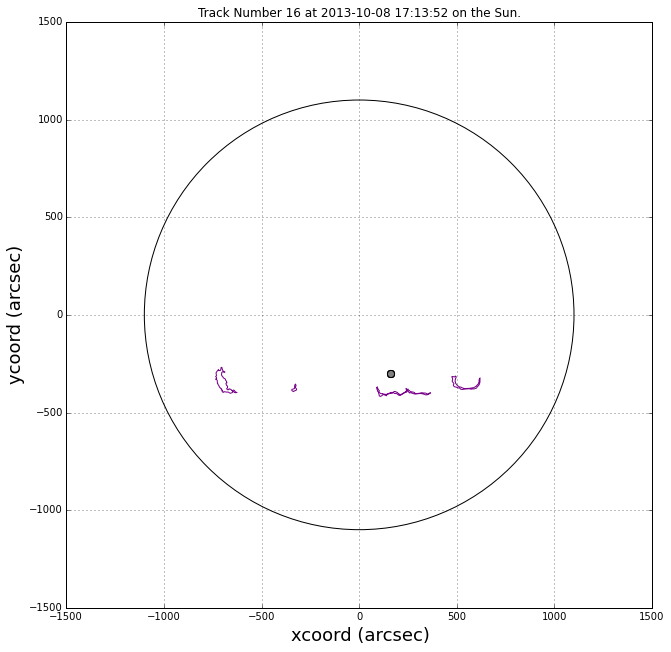

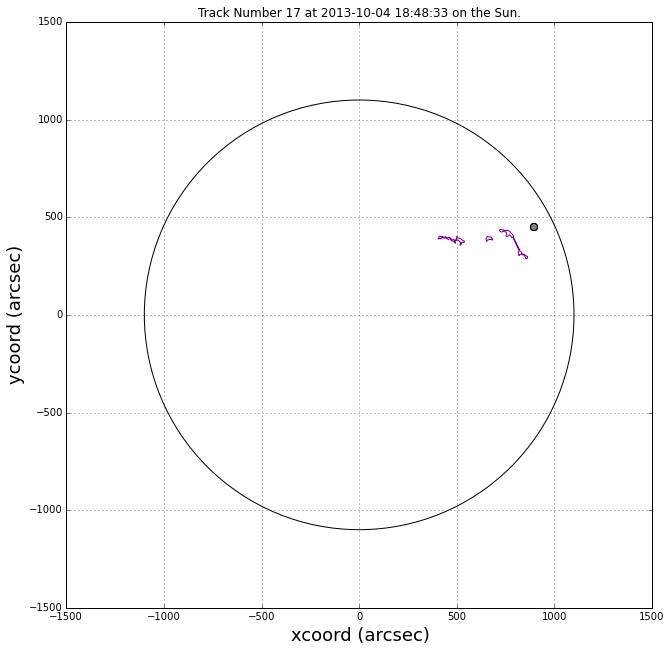

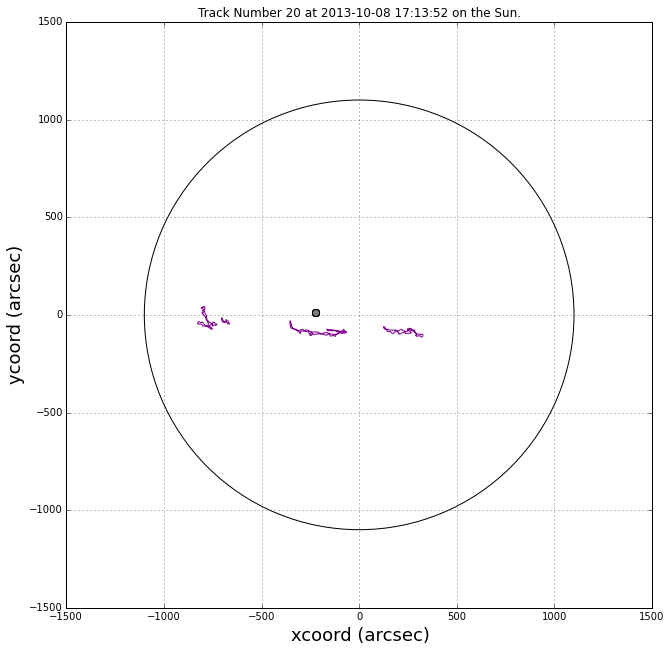

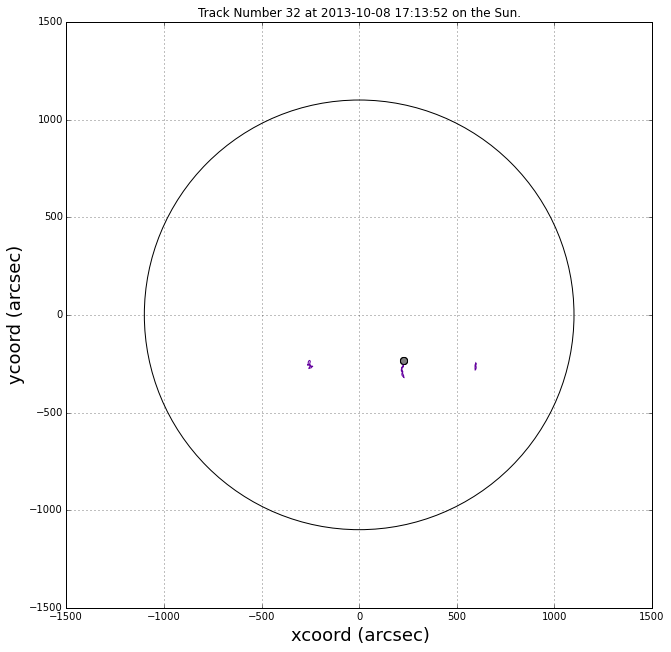

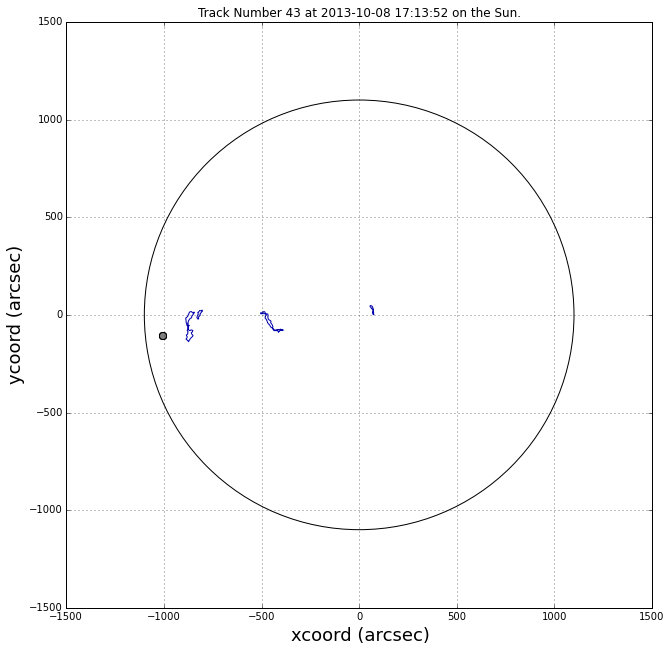

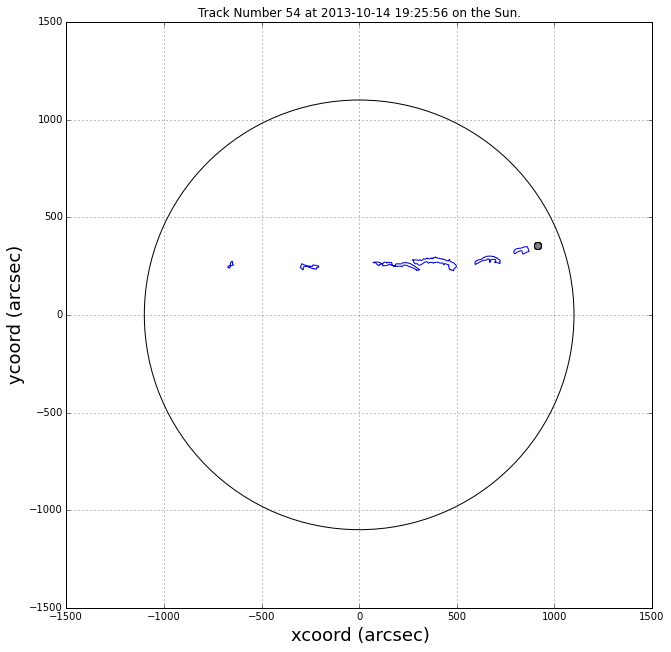

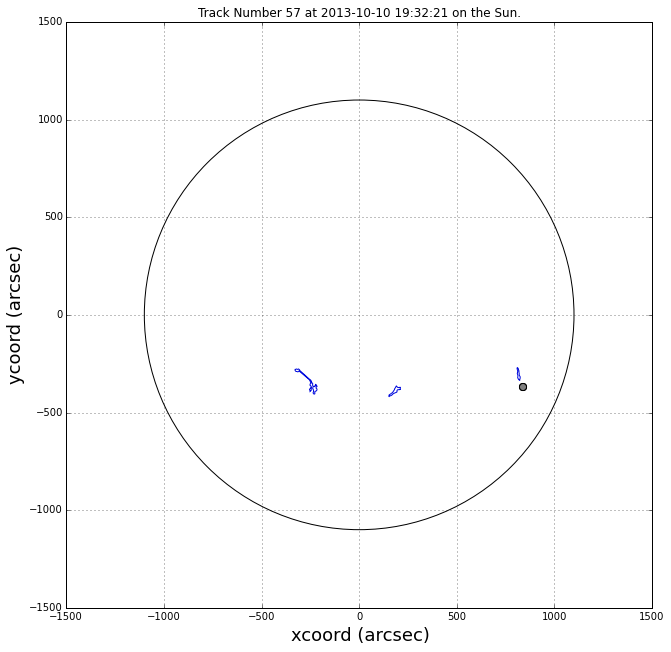

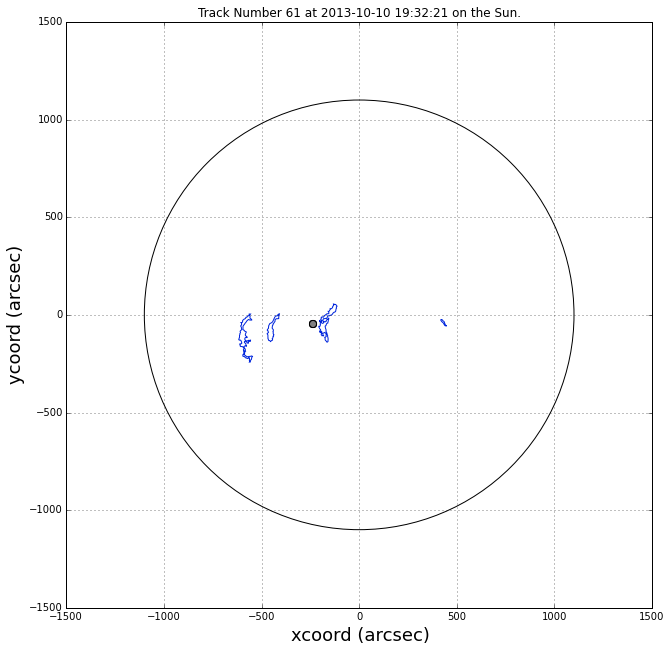

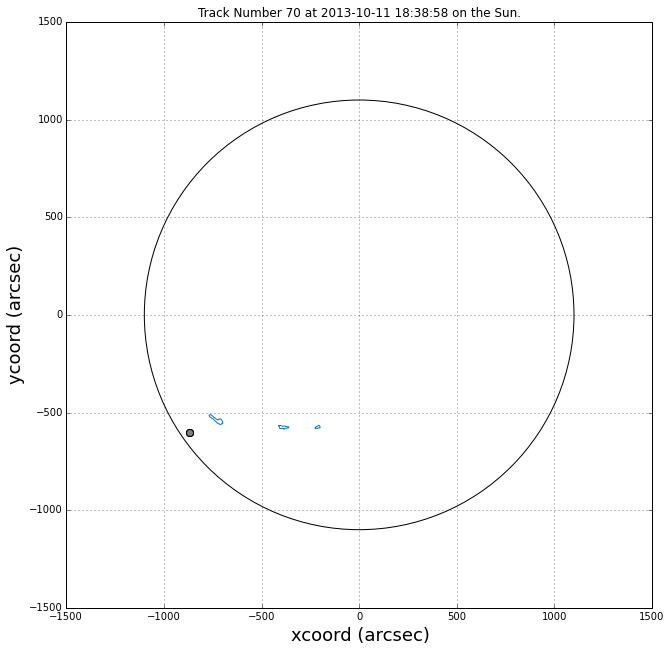

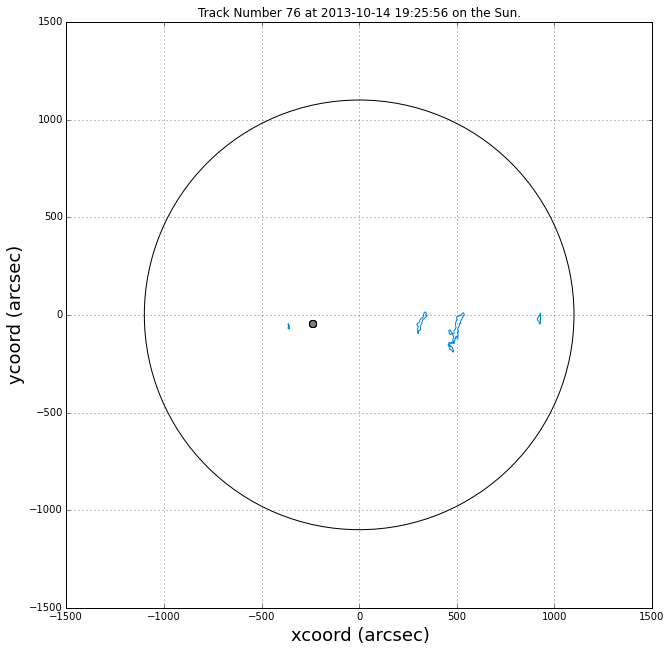

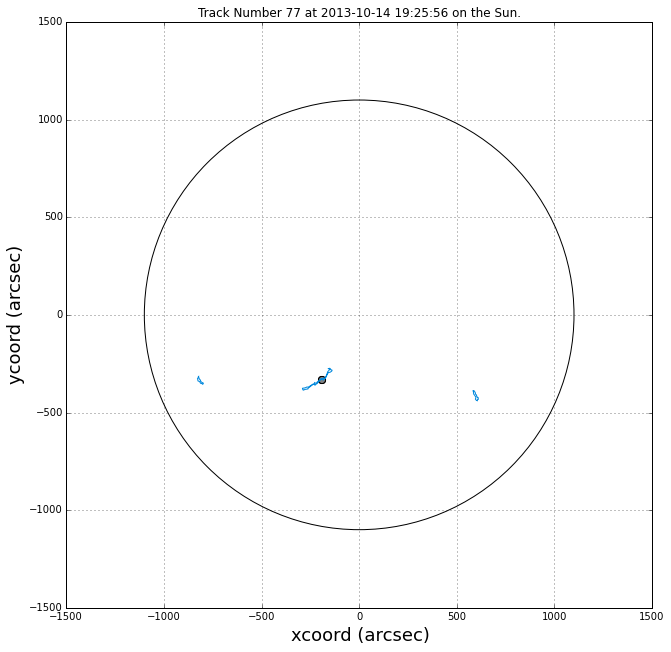

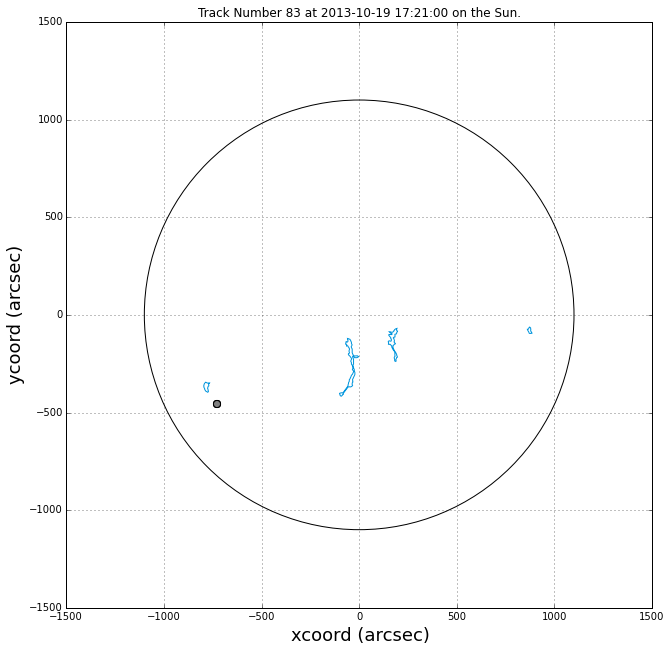

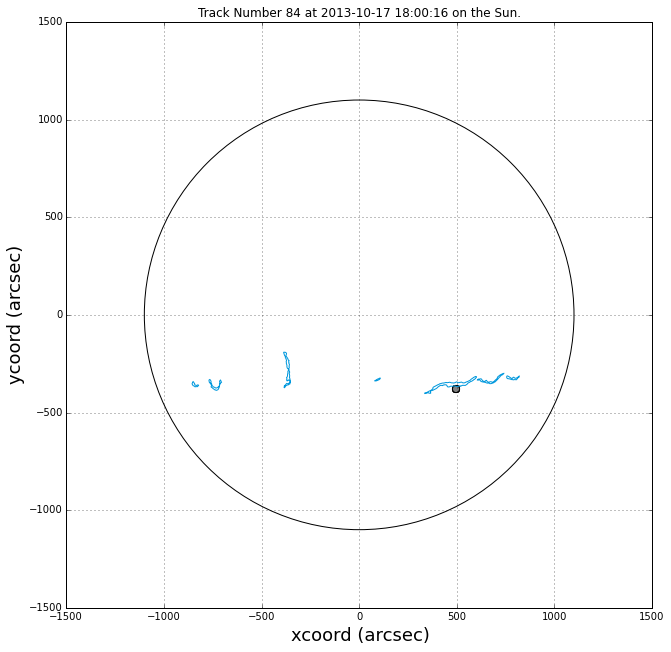

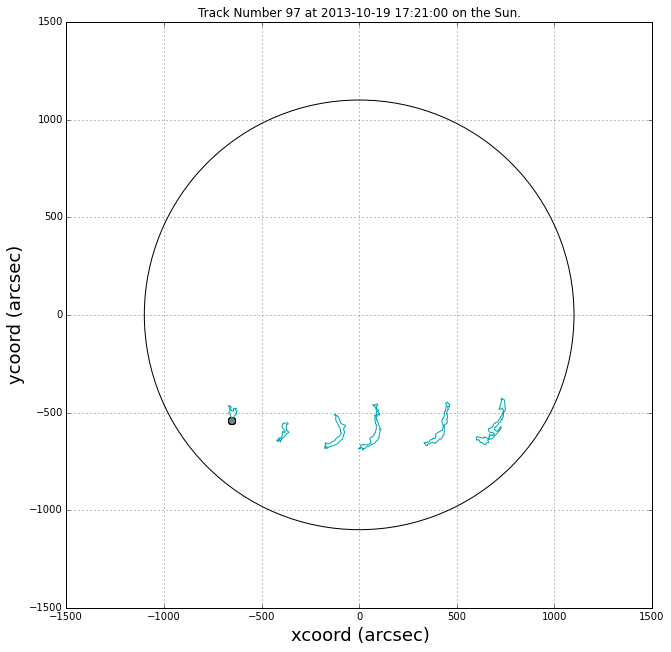

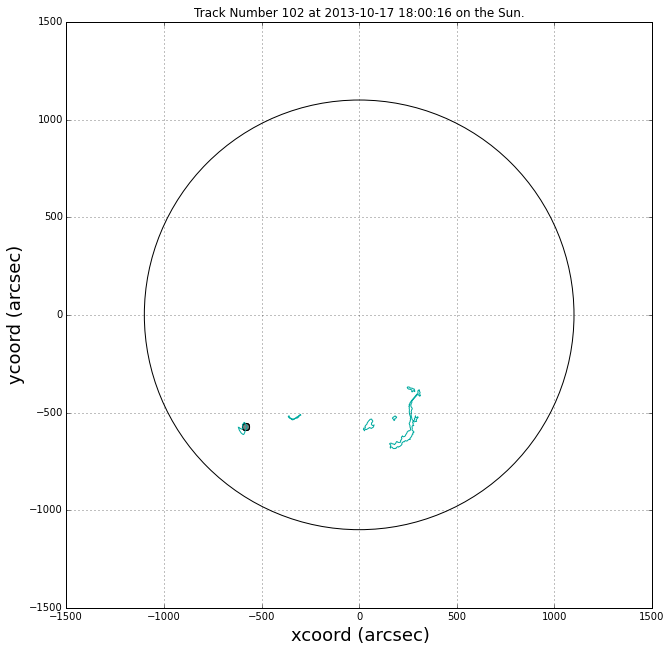

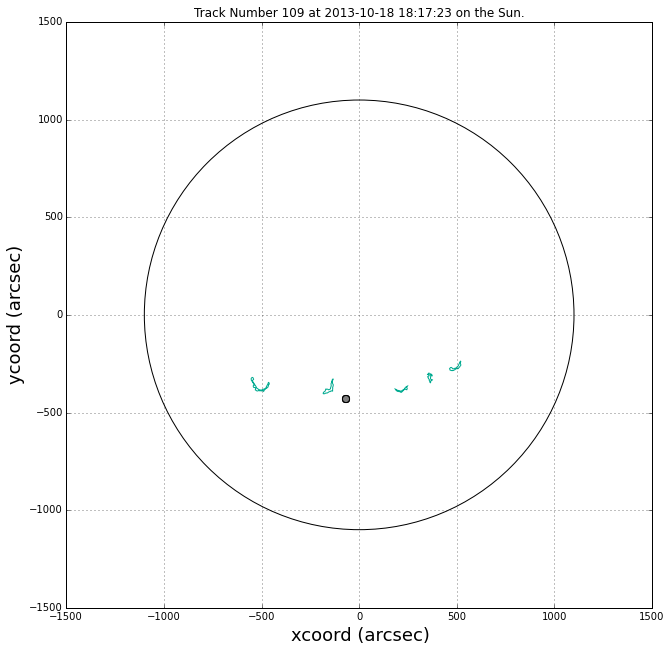

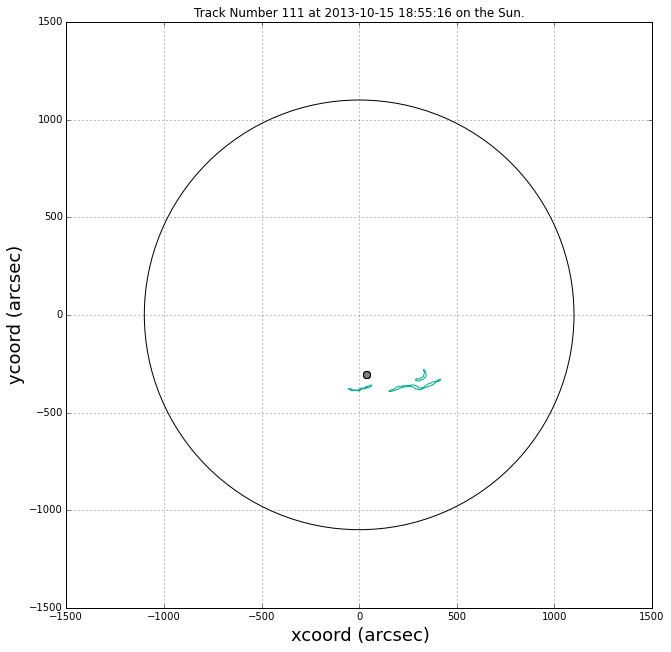

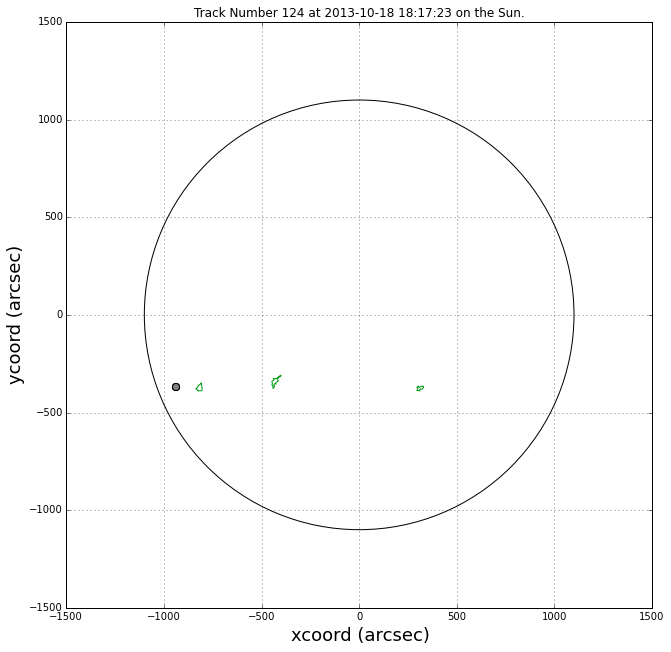

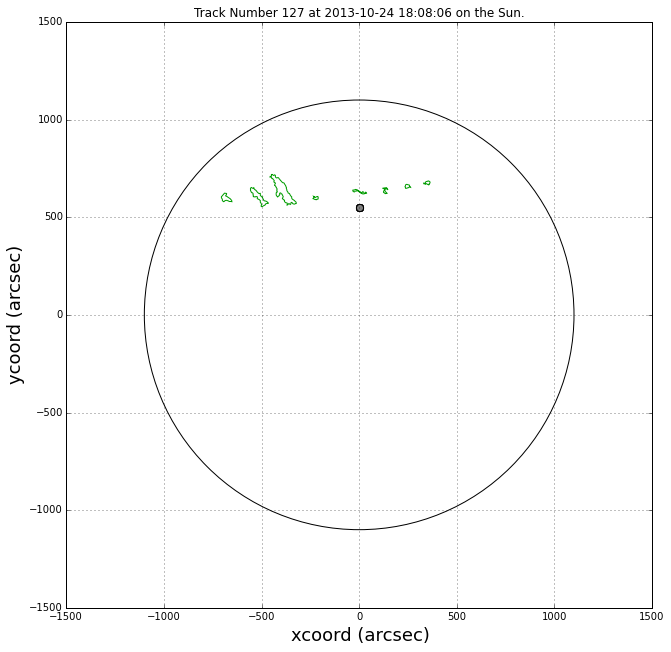

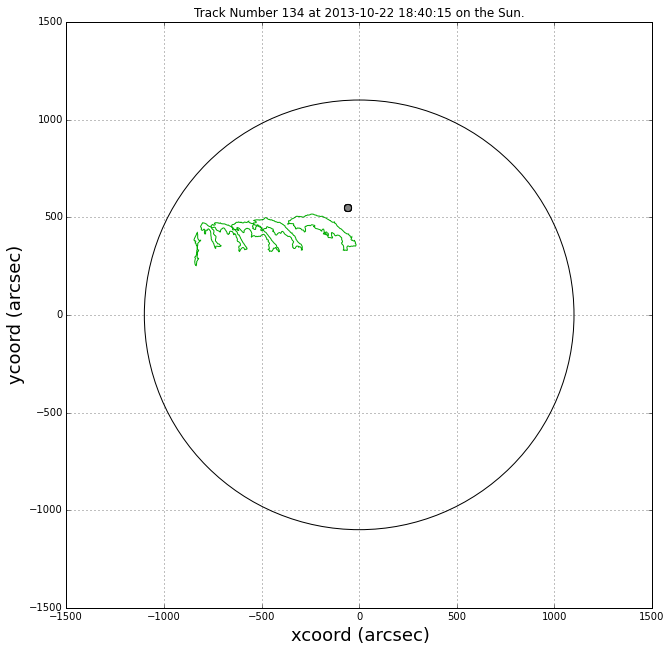

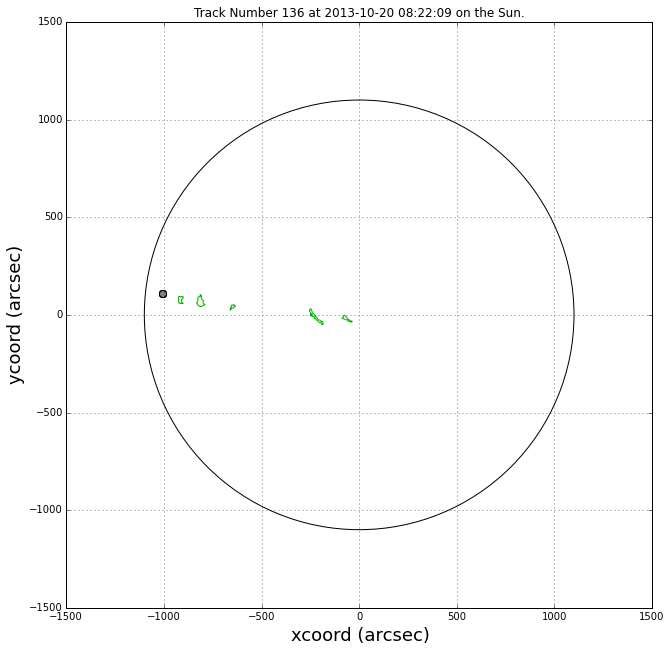

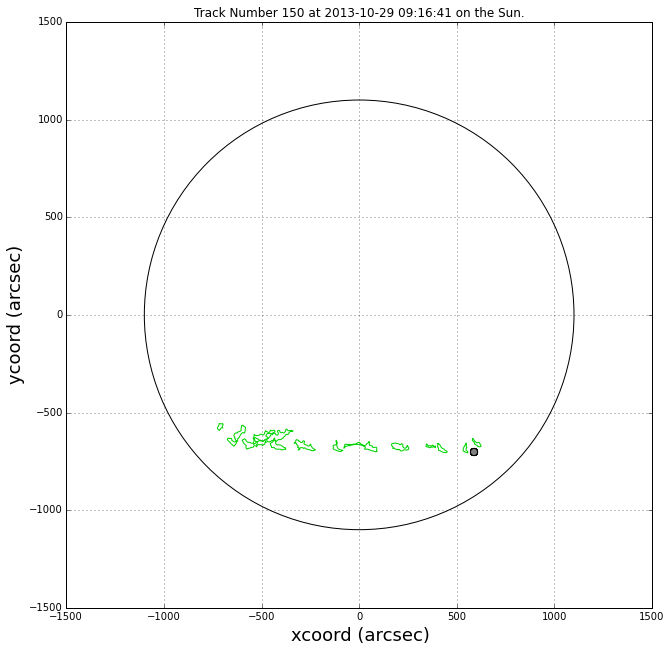

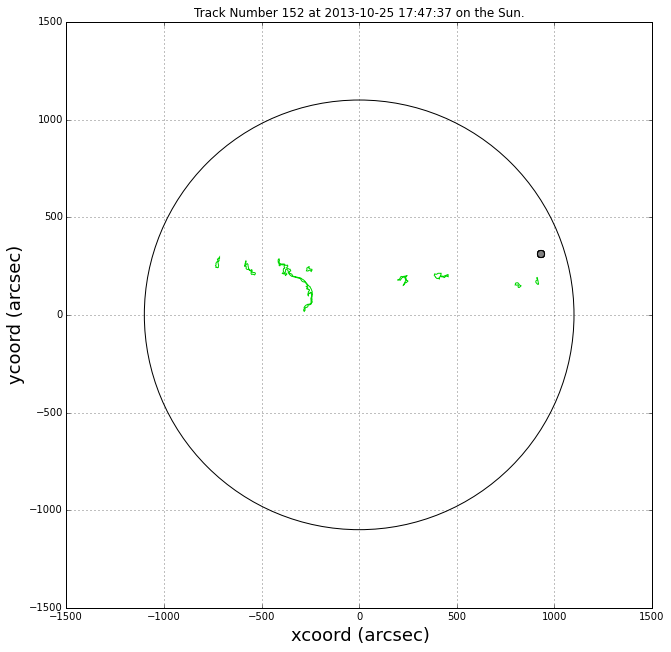

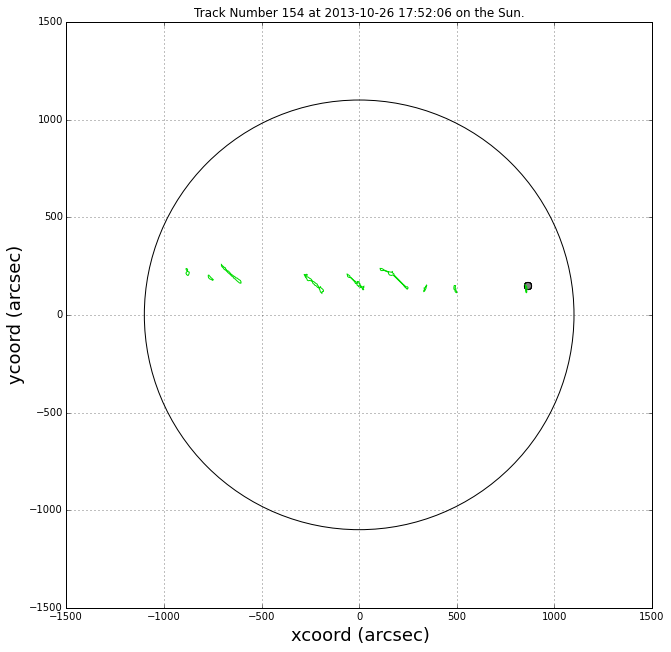

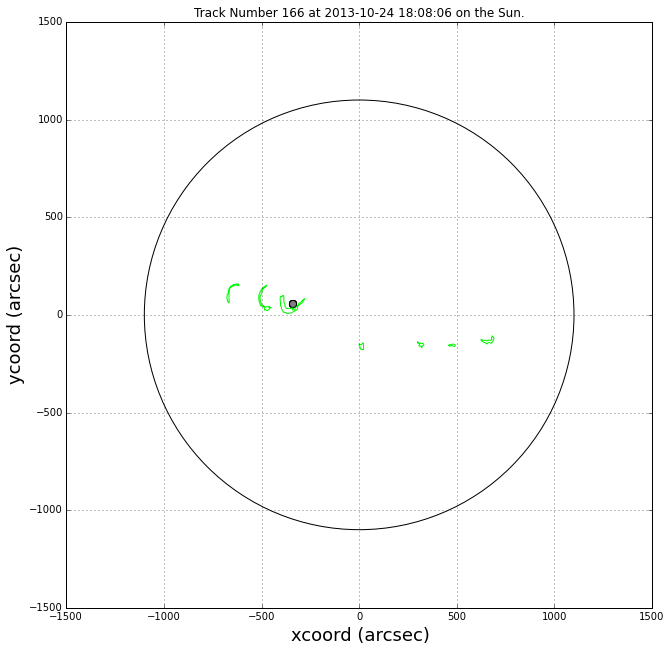

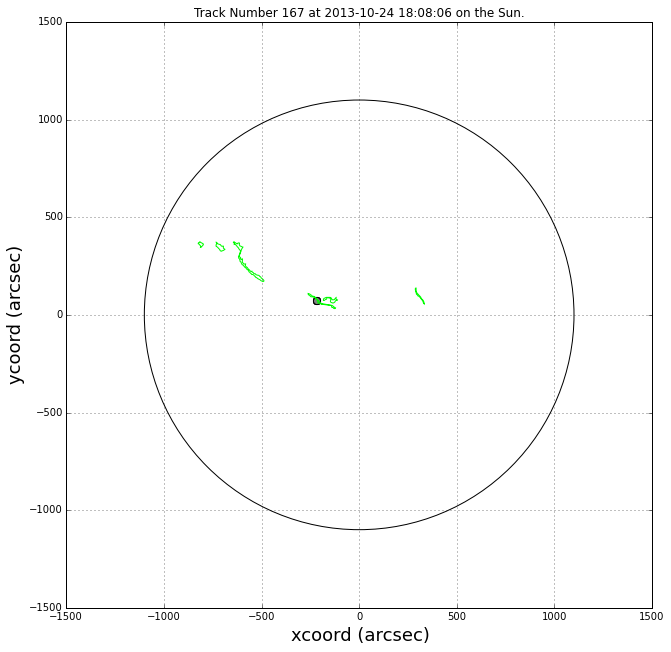

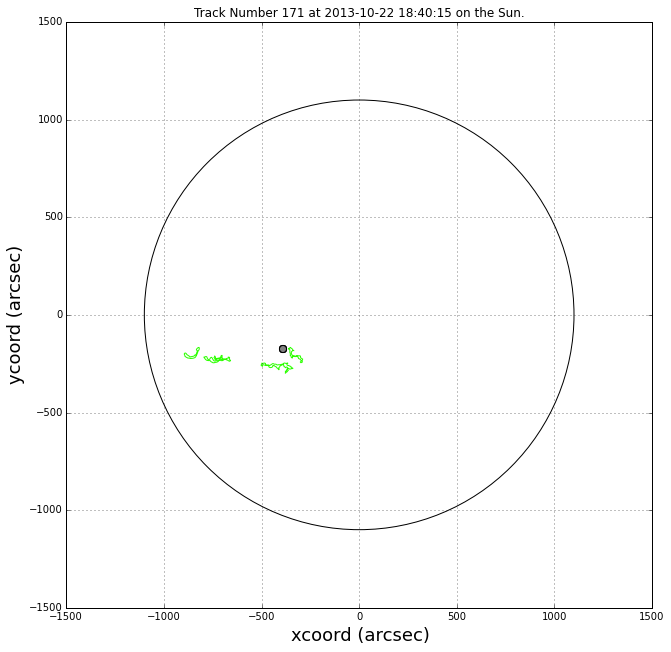

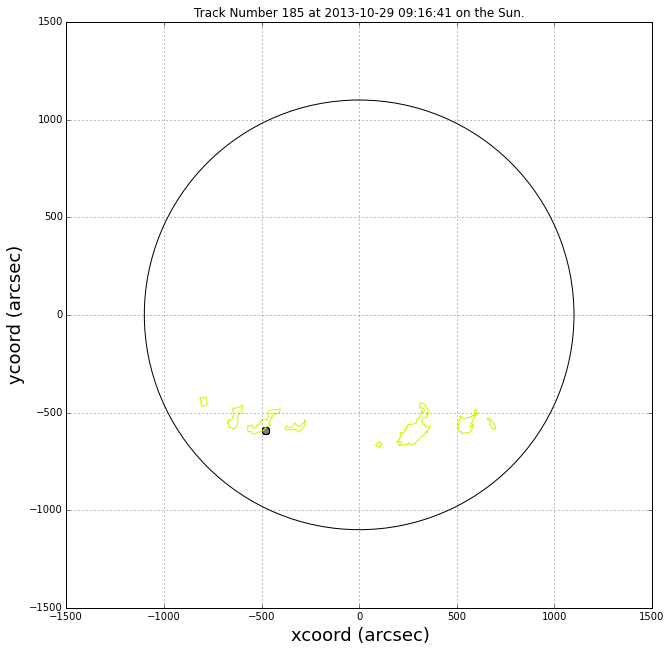

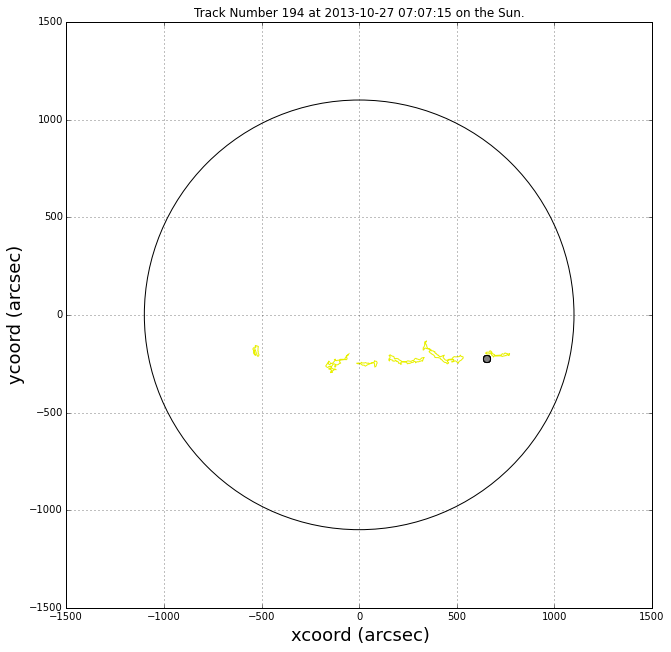

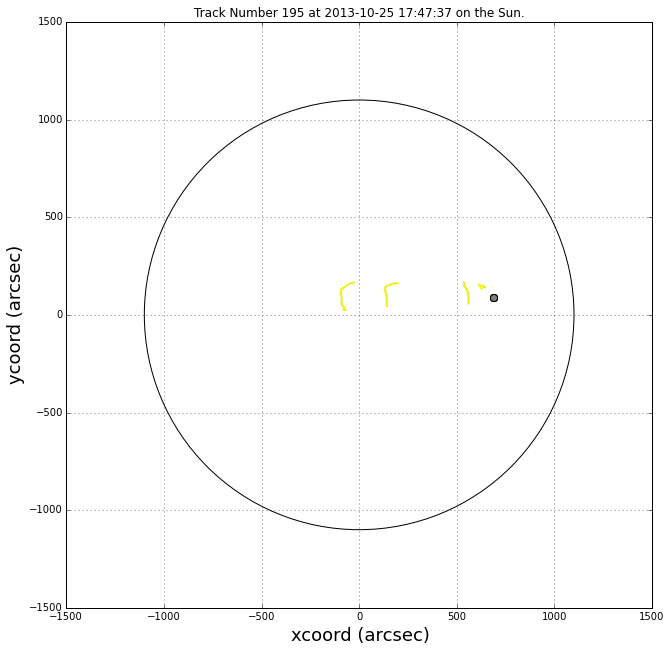

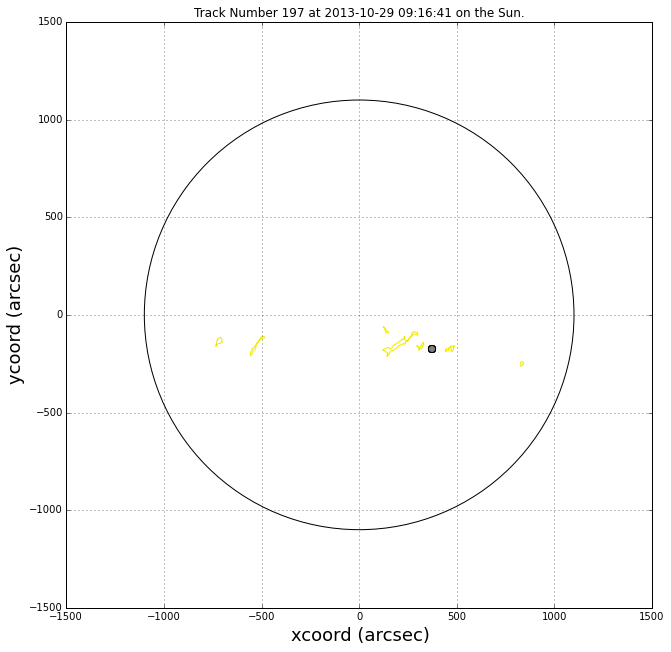

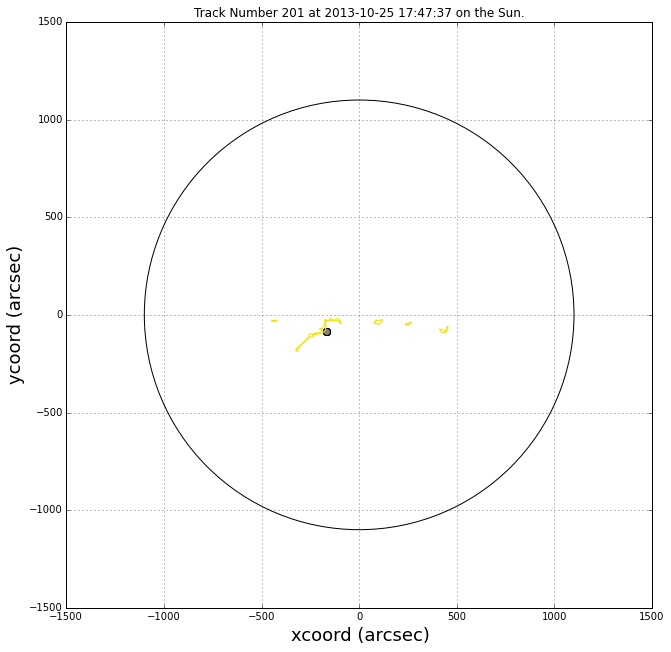

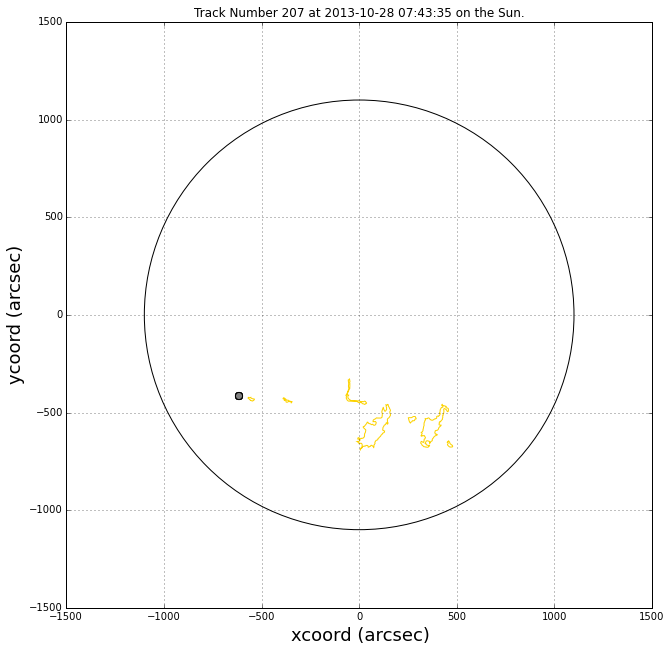

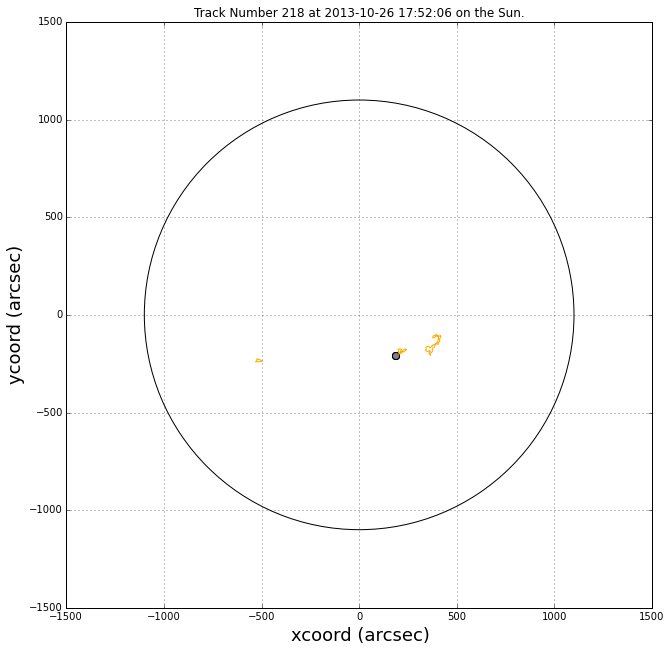

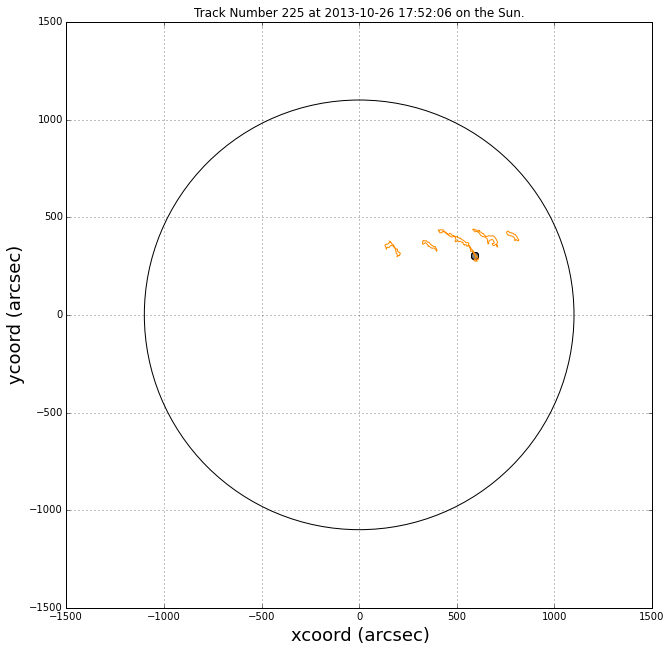

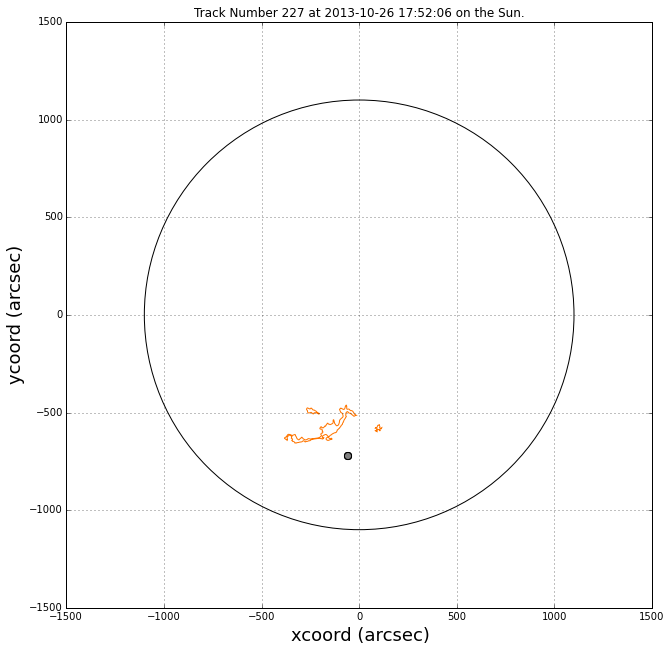

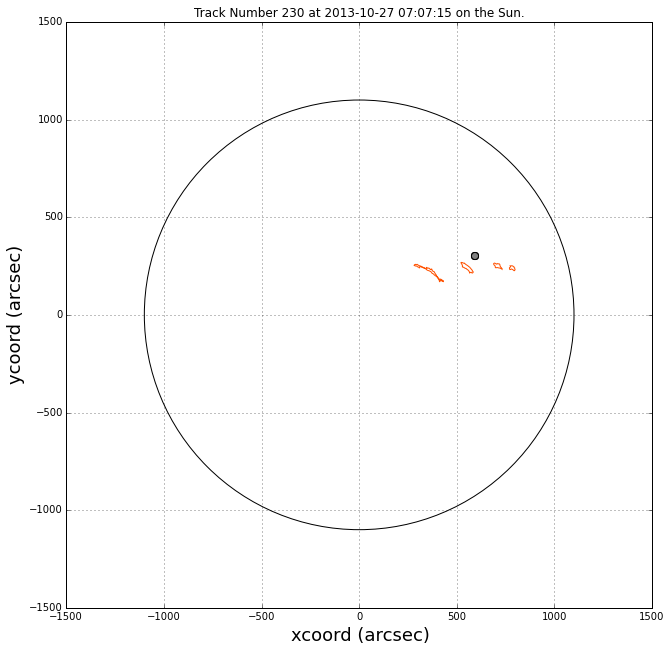

In [115]:

#######################
filtered4=[]
erupind=[]
tot=[]
unique=[]
close_unique=np.unique(close)
for tracks in close_unique:
    tot.append(unique)
    unique=[]
    for i in range(0, len(good_tracks)):
        if tracks == good_tracks['Track No.'][i]:
            unique.append(i)

tot.pop(0)
for item in tot:
    colorscale2=[]
    norm = mpl.colors.Normalize(vmin=0, vmax=280)
    cmap = plt.get_cmap('nipy_spectral')
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for thing in close: #plotting those filaments that have eruptions contained within them
        scaleR= m.to_rgba(thing) 
        colorscale2.append(scaleR)
    
####plots eruptions/sun
    plt.grid(True)
    plt.ylabel('ycoord (arcsec)',fontsize=18)
    plt.xlabel('xcoord (arcsec)',fontsize=18)
    plt.axis([-1500, 1500, -1500, 1500])
    #filtered4=[eruptions[i] for i in erupind]
    #longitude = [elem["hpc_x"]for elem in filtered3]
    #latitude = [elem["hpc_y"] for elem in filtered3]
    #fig=plt.scatter(longitude,latitude, c = colorscale2,s=50)
    Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
    plt.gcf().gca().add_artist(Sun)
    #plt.title('Track (%s) on the Sun October 2013', )
    fig1 = plt.gcf()
    fig1.set_size_inches(10.5,10.5)
    ax = fig1.add_subplot(111)
    ax.set_aspect('equal')
    erupind=[]
    print ''
    for i in range(0, len(item)):
        j=item[i]
        trnum=  good_tracks['Track No.'][j]
        stime=  good_tracks['HEK_time'][j]
        for thing1 in corresponding:
            if thing1[0] == trnum:
                erupind.append(thing1[1])
        verup=[indices[i] for i in erupind]   #getting the eruption index from a list of possible indices
        erupind=[]
        filtered4=[eruptions[k] for k in verup]
        longitude = [elem["hpc_x"]for elem in filtered4]
        latitude = [elem["hpc_y"] for elem in filtered4]
        fig=plt.scatter(longitude,latitude, c = 'grey',s=50)
        scale2=m.to_rgba(good_tracks['Track No.'][j])
        plot_polygon=plt.Polygon(loads(good_tracks['HPC_BB_Poly'][j]).exterior,color=scale2,linewidth=1,fill=None)
        fig1.gca().add_artist(plot_polygon)
        plt.title('Track Number %(Trackno)d at %(starttime)s on the Sun.' % {"Trackno" : trnum, "starttime": stime})
    plt.show()
            

# The next two kernels use the list "practice" which contains track number and associated eruption time, to make a new list called "step" which contains track number, polygon length, eruption time, and track time. then, they are plotted in a series of plots

In [116]:
final=[16.0, 62.0, 226.0, 233.0, 73.0, 134.0, 54.0, 185.0, 227.0, 127.0] #this a manual input list of all tracks that correlated to eurptions (visually)
find=list(set(close) & set(final))    #finds the intersection of tracks we have data for, and tracks that erupted 
print close
step=[]
bad=[]
for p in practice:  #practice has track number associated with eruption time  
    for tracks in find:
        for i in range(0, len(good_tracks)):
            if good_tracks['Track No.'][i] == p[1]:   ##checks for the right eruption time 
                if good_tracks['Track No.'][i] == tracks:  ### next line should append time of each event, the trakc number, and the length of each polygon
                    if [tracks, parse(good_tracks['HEK_time'][i]), good_tracks['fi_length'][i], parse_time(p[0])] not in step:
                        step.append([tracks, parse(good_tracks['HEK_time'][i]), good_tracks['fi_length'][i], parse_time(p[0])])

[16.0, 17.0, 20.0, 32.0, 43.0, 54.0, 57.0, 61.0, 70.0, 76.0, 77.0, 83.0, 84.0, 97.0, 102.0, 109.0, 111.0, 124.0, 127.0, 134.0, 136.0, 150.0, 152.0, 154.0, 166.0, 167.0, 171.0, 185.0, 194.0, 195.0, 197.0, 201.0, 207.0, 218.0, 225.0, 227.0, 230.0, 233.0]


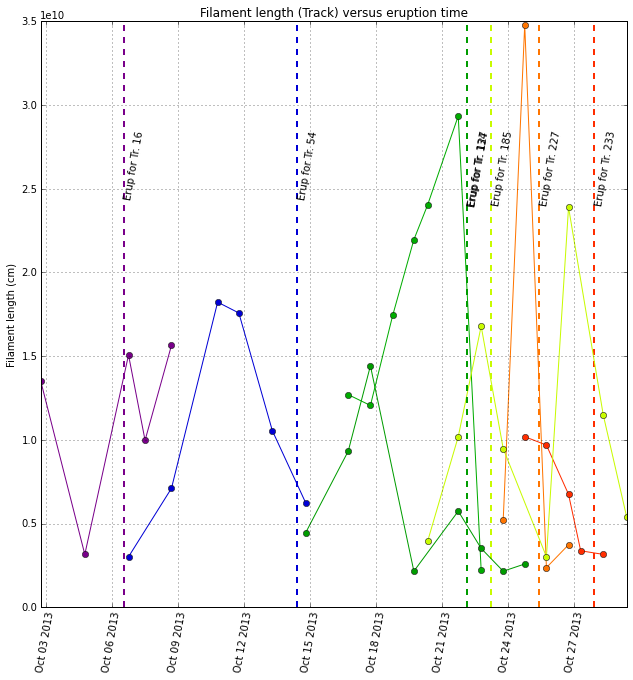

In [69]:
colorscale2=[]
norm = mpl.colors.Normalize(vmin=0, vmax=280)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
interest=[]
x=[]
y=[]
t=[]
for track in find:
    scale3=m.to_rgba(track)
    x=[] ### will be time data
    y=[] ## will be length data 
    r=[]
    t=[]
    interest=[]
    emp=[]
    for r in step:      #iterates through the data 
        if r[0] == track:  #finds the correct track
            if r not in interest:
                 interest.append(r)   #appends the data to a new list
    for k in range(0, len(interest)):
        t2= interest[k][3]
        t1=interest[k][1]
        t3=t2-t1
        t.append(t3.seconds)
        x.append(t1)
        y.append(interest[k][2])
    plt.plot_date(x, y, xdate=True,ydate=False, color=scale3, linestyle='-')
    plt.axvline(interest[k][3], linewidth=2, color=scale3, linestyle='--', label='eruption')
    plt.text(interest[k][3], 28000000000,'Erup for Tr. %(Trackno)d' %{"Trackno": track},rotation=80)
    #ax.xaxis.set_major_locator(AutoDateLocator())
    plt.title('Filament length (Track) versus eruption time')
    plt.grid(True)
    fig1 = plt.gcf()
    fig1.set_size_inches(10.5,10.5)
    plt.xticks( rotation= 80 )
    plt.ylabel('Filament length (cm)')
plt.show()

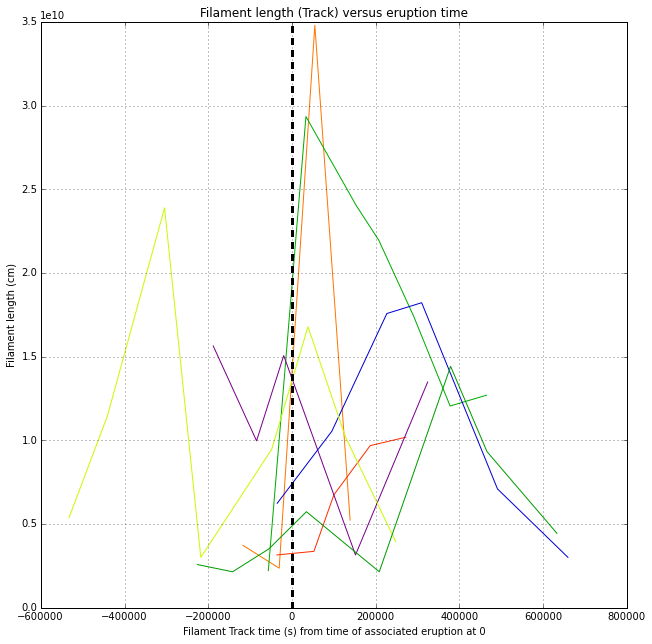

In [114]:
colorscale2=[]
norm = mpl.colors.Normalize(vmin=0, vmax=280)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
interest=[]
x=[]
y=[]
t=[]
for track in find:
    scale3=m.to_rgba(track)
    x=[] ### will be time data
    y=[] ## will be length data 
    r=[]
    t=[]
    interest=[]
    emp=[]
    for r in step:      #iterates through the data 
        if r[0] == track:  #finds the correct track
            if r not in interest:
                 interest.append(r)   #appends the data to a new list
    for k in range(0, len(interest)):
        t2= interest[k][3]    ##eruption time
        t1=interest[k][1]    #filament time
        t3=timedelta.total_seconds(t2-t1)
        t.append(int(t3))
        y.append(interest[k][2])
    plt.plot(t, y, color=scale3)
    plt.axvline(0, linewidth=3, color='k', linestyle='--', label='Eruption')
    plt.title('Filament length (Track) versus eruption time')
    plt.grid(True)
    fig1 = plt.gcf()
    fig1.set_size_inches(10.5,10.5)
    plt.xlabel('Filament Track time (s) from time of associated eruption at 0')
    plt.ylabel('Filament length (cm)')
plt.show()

check tracks: 83, 84, 97, 102, 154, 185, 194, 230

Track 16 does erupt on 10/2.  ######
Track 62 does erupt on 10/06 on the lower East limb. Hard to see! Its small. ######### 
Track 127 does erupt on 10/18 upper East. #####
Track 150 does erupt. ##### OR
Track 226 does erupt on 10/25 ####
Track 233 might erupt right on the West limb on 10/28. ####### 
Track 17 (not in the list because length is less than 3) DOES erupt on 10/9. ######
Track 134 does erupt around 10/22. ########
Track 54 does seem to erupt around 10/17 on the mid West Limb. ##########
Track 97 does seem to erupt around 10/20 on the Lower West Limb. ######


 def eventtime(tstart, tend):   #allows the user to input a custom date
    date=tstart+tend
    print(date)
    result=[]
    indices=[]
    eruptions = client.query(hek.attrs.Time(tstart,tend),hek.attrs.EventType(event_type))
    len(eruptions)
    vso_records = h2v.translate_and_query(eruptions[10])
    len(vso_records)
    #print(len(eruptions), len(vso_records))
    times=[elem["event_starttime"] for elem in eruptions] 
### the following loop will remove identical eruptions that have been recorded at different wavelengths by sorting with time
    for element in times:
        if element not in result:
            indices.append((times.index(element)))
            result.append(element)
            
    filtered=[eruptions[i] for i in indices]
    #####################################################
    longitude = [elem["hpc_x"] for elem in filtered]
    latitude = [elem["hpc_y"] for elem in filtered]
    fig=plt.scatter(longitude,latitude,color='gray',s=50) ###plots data points according to location
#ax=fig.add_subplot(1,1,1)
    Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
    plt.gcf().gca().add_artist(Sun)
    plt.ylabel('arcsec')
    plt.xlabel('arcsec')
    plt.ylim(-1500, 1500)
    plt.title('Filament Eruptions on the Sun from '+ tstart + ' to ' + tend)
    plt.grid()
    plt.show()
    plt.savefig('willbevariable.png')

In [73]:
big_track=np.unique(big_track)
print len(big_track)
big_polygons=[]
for i in range(len(good_tracks)): #iterating through the whole list of tracks 
    if good_tracks['Track No.'][i] in big_track:  #if the track number is in the lists created previously 
         big_polygons.append((good_tracks['Track No.'][i],good_tracks['HPC_BB_Poly'][i]))#append the polygon data to good polygons

25



2013-10-02 18:53:22
2013-10-03 17:57:44
2013-10-04 18:48:33
2013-10-05 07:01:29
2013-10-06 18:26:57


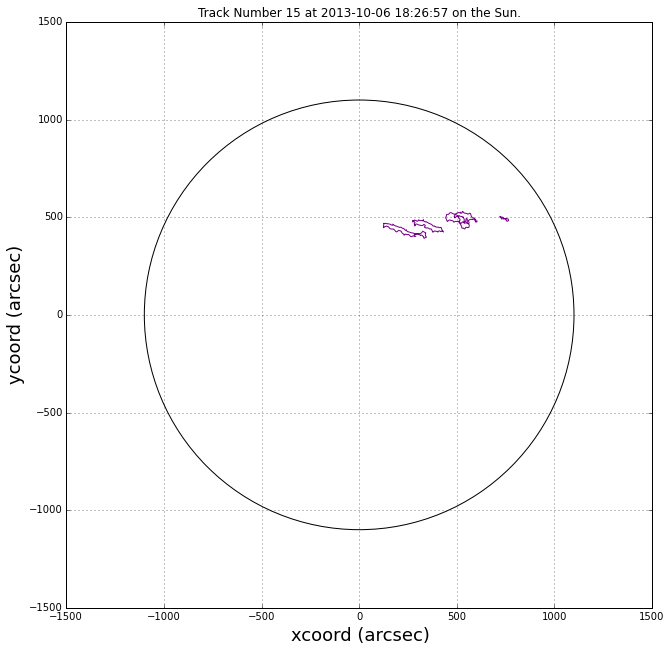


2013-10-02 18:53:22
2013-10-04 18:48:33
2013-10-06 18:26:57
2013-10-07 12:28:11
2013-10-08 17:13:52


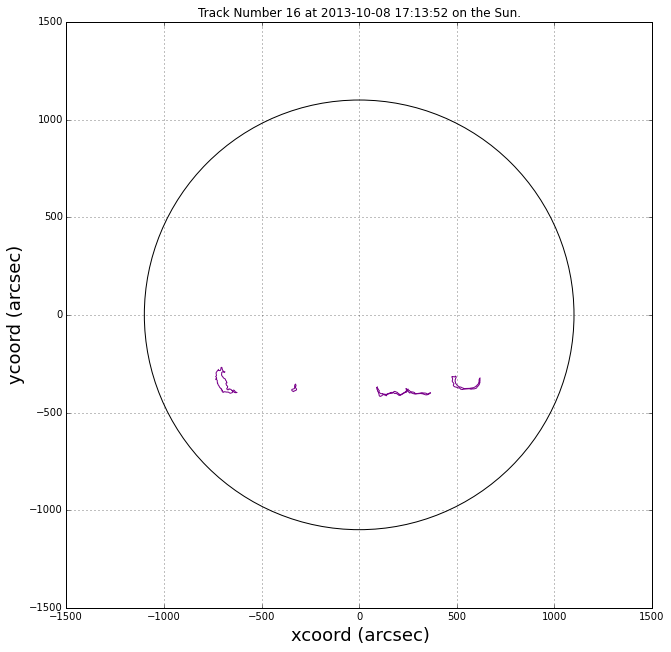


2013-10-06 18:26:57
2013-10-08 17:13:52
2013-10-10 19:32:21
2013-10-11 18:38:58
2013-10-13 07:09:10
2013-10-14 19:25:56


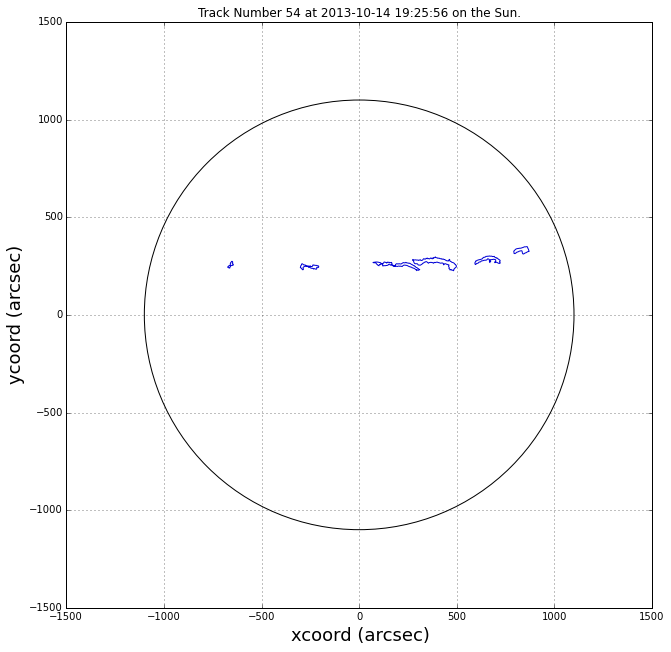


2013-10-06 18:26:57
2013-10-07 12:28:11
2013-10-08 17:13:52
2013-10-10 19:32:21


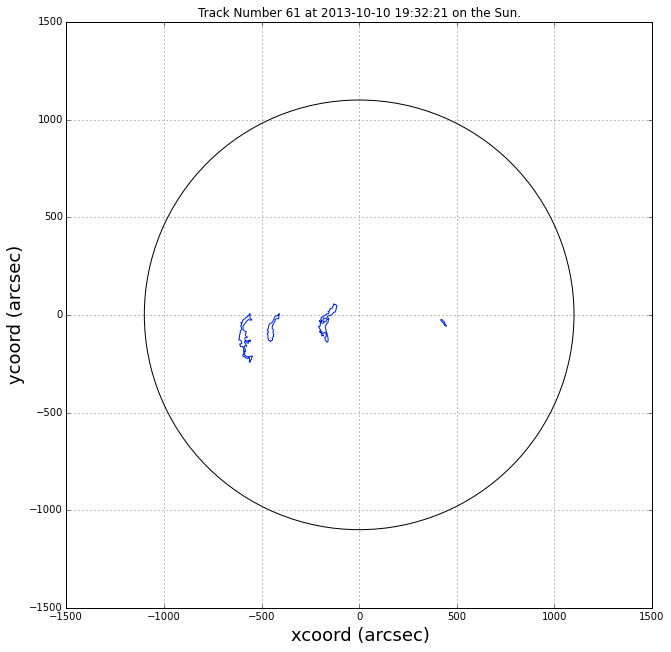


2013-10-06 18:26:57
2013-10-07 12:28:11
2013-10-08 17:13:52


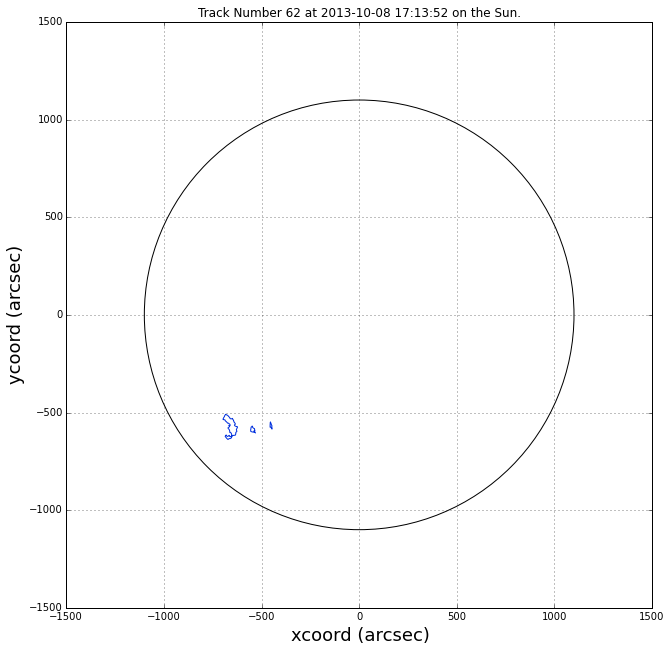


2013-10-08 17:13:52
2013-10-10 19:32:21
2013-10-11 18:38:58
2013-10-13 07:09:10


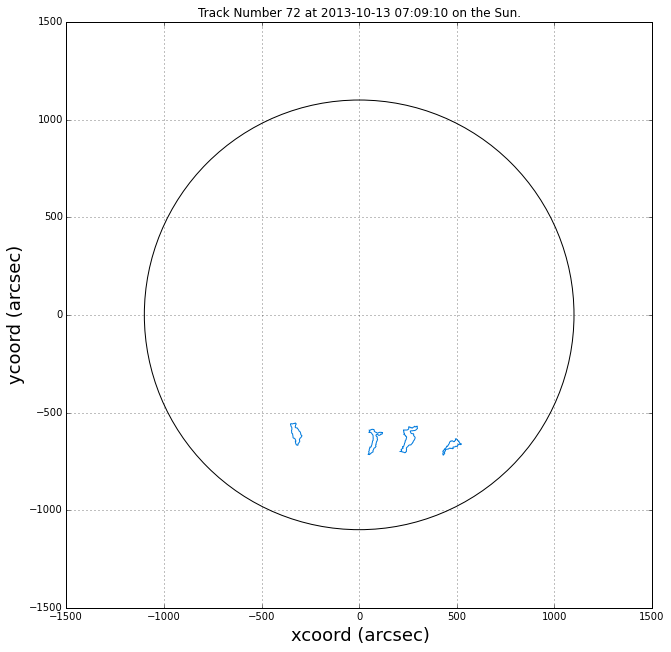


2013-10-08 17:13:52
2013-10-10 19:32:21
2013-10-11 18:38:58
2013-10-14 19:25:56


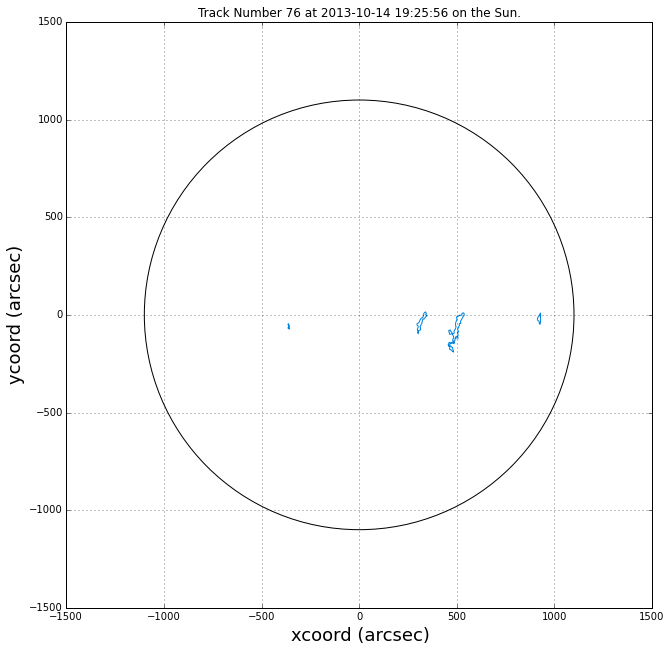


2013-10-10 19:32:21
2013-10-14 19:25:56
2013-10-15 18:55:16
2013-10-19 17:21:00


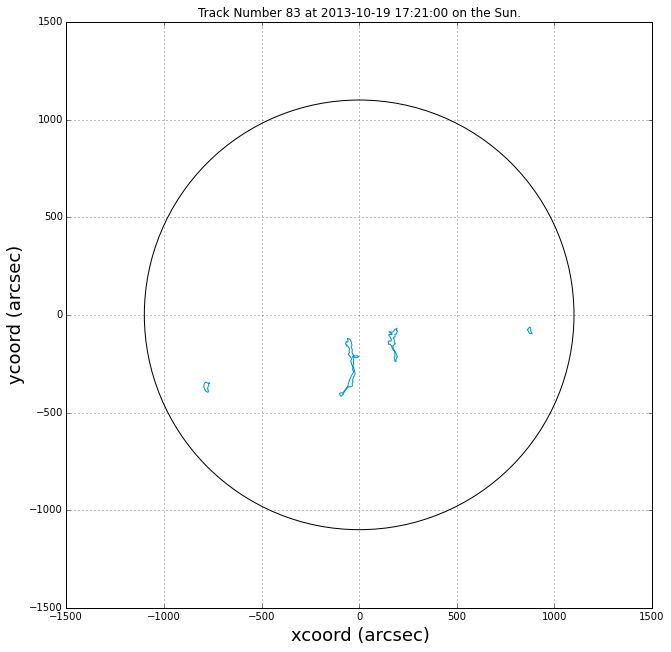


2013-10-11 18:38:58
2013-10-13 07:09:10
2013-10-14 19:25:56
2013-10-15 18:55:16
2013-10-17 18:00:16
2013-10-19 17:21:00


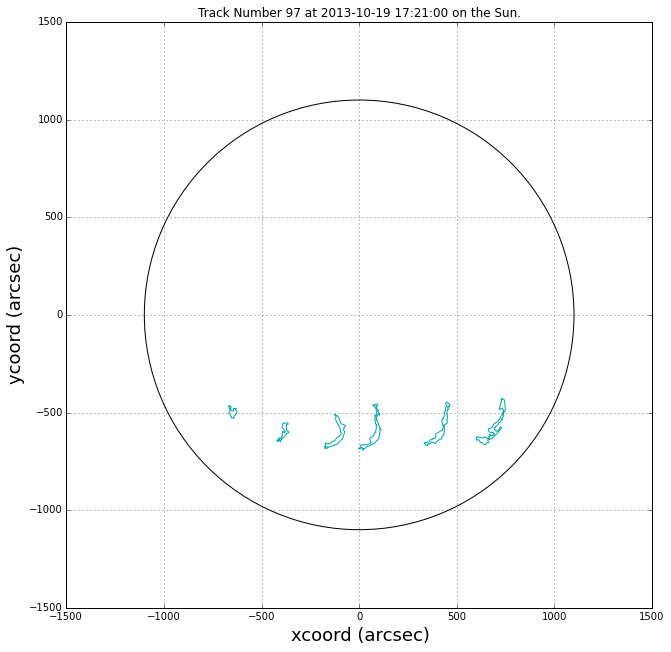


2013-10-11 18:38:58
2013-10-13 07:09:10
2013-10-14 19:25:56
2013-10-15 18:55:16
2013-10-16 17:50:59
2013-10-17 18:00:16


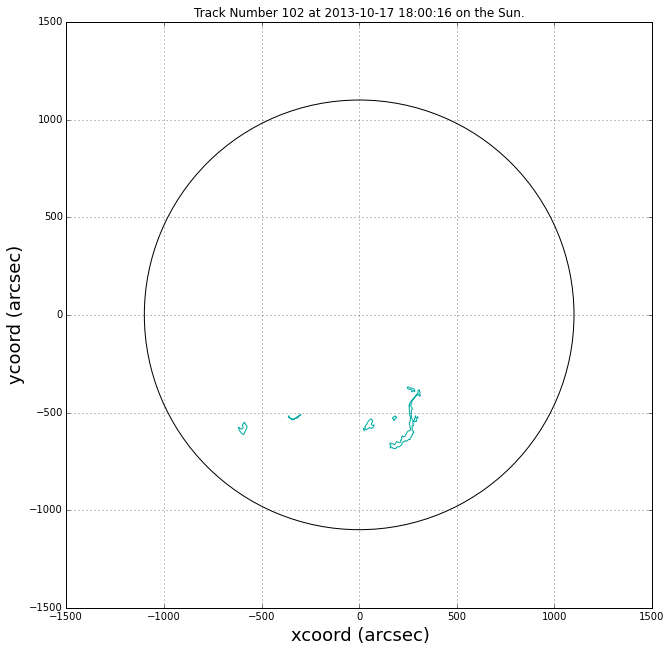


2013-10-14 19:25:56
2013-10-15 18:55:16
2013-10-16 17:50:59
2013-10-17 18:00:16


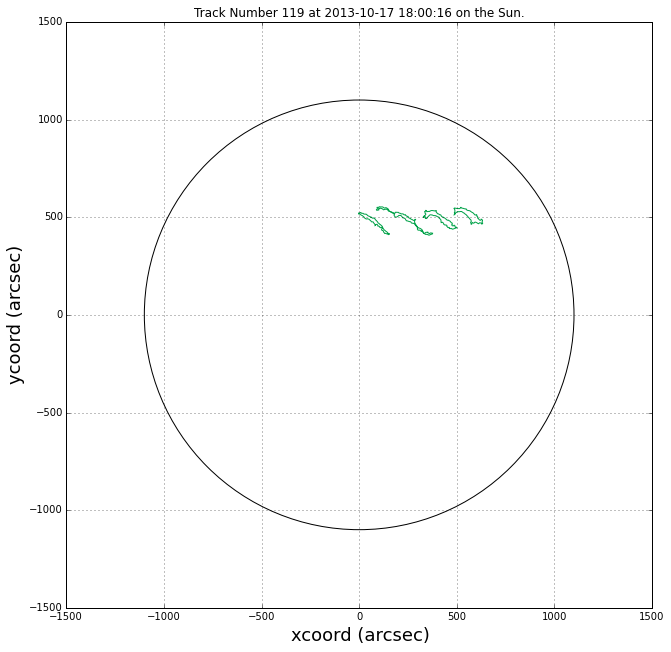


2013-10-14 19:25:56
2013-10-16 17:50:59
2013-10-17 18:00:16
2013-10-19 17:21:00
2013-10-21 17:42:11
2013-10-22 18:40:15
2013-10-23 18:42:48
2013-10-24 18:08:06


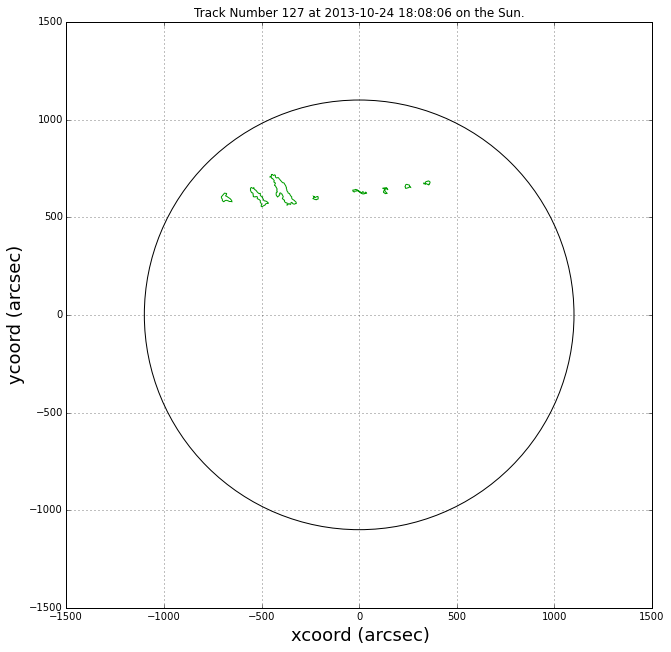


2013-10-15 18:55:16
2013-10-16 17:50:59
2013-10-17 18:00:16
2013-10-18 18:17:23
2013-10-21 17:42:11
2013-10-22 18:40:15
2013-10-23 18:42:48


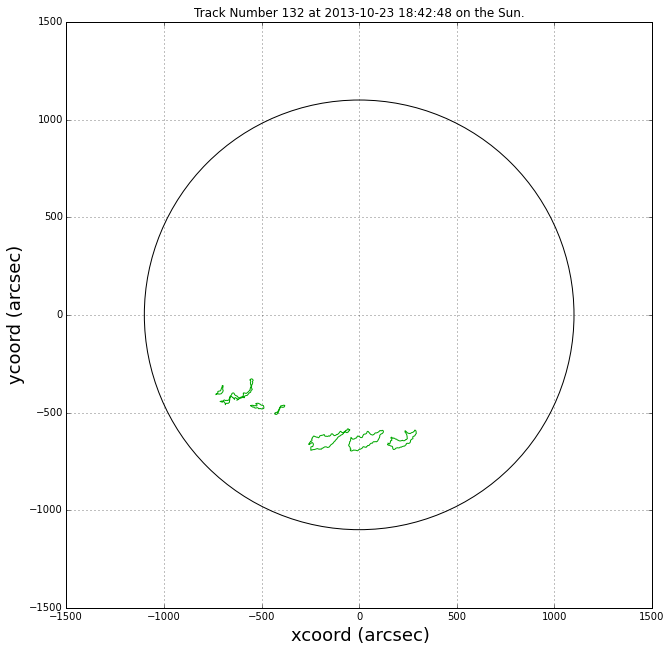


2013-10-16 17:50:59
2013-10-17 18:00:16
2013-10-18 18:17:23
2013-10-19 17:21:00
2013-10-20 08:22:09
2013-10-21 17:42:11
2013-10-22 18:40:15


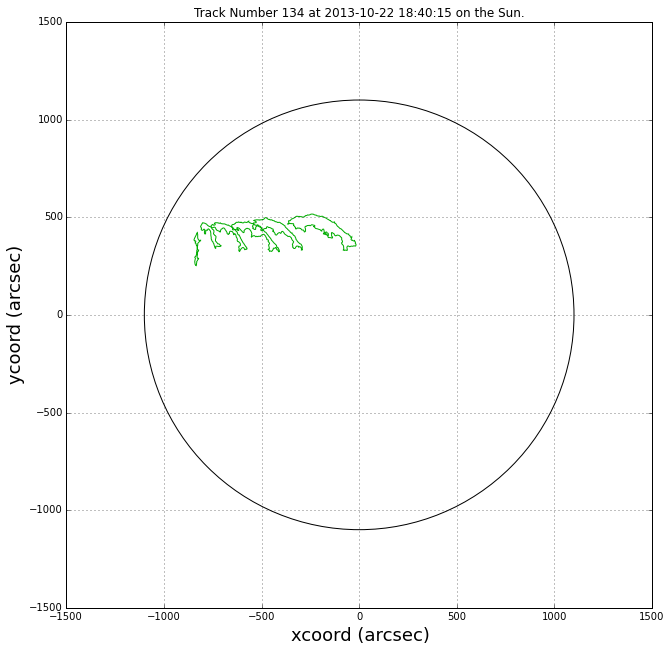


2013-10-16 17:50:59
2013-10-17 18:00:16
2013-10-18 18:17:23
2013-10-19 17:21:00


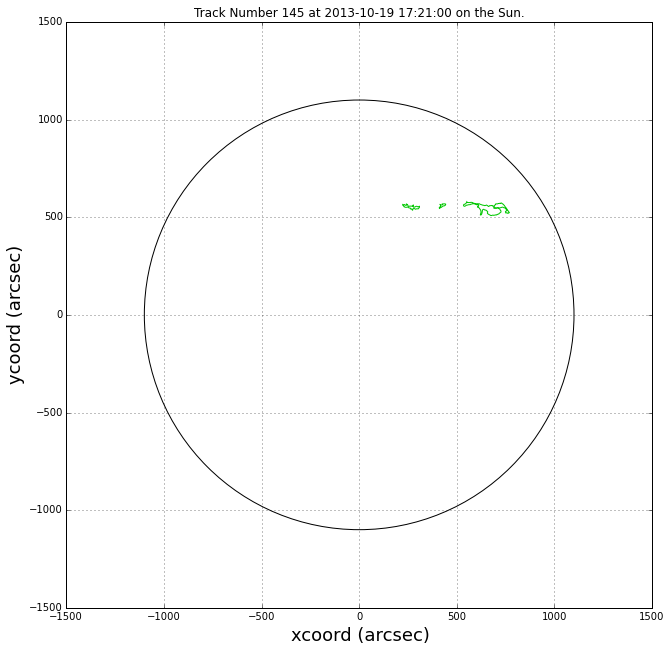


2013-10-16 17:50:59
2013-10-17 18:00:16
2013-10-18 18:17:23
2013-10-19 17:21:00
2013-10-20 08:22:09
2013-10-21 17:42:11


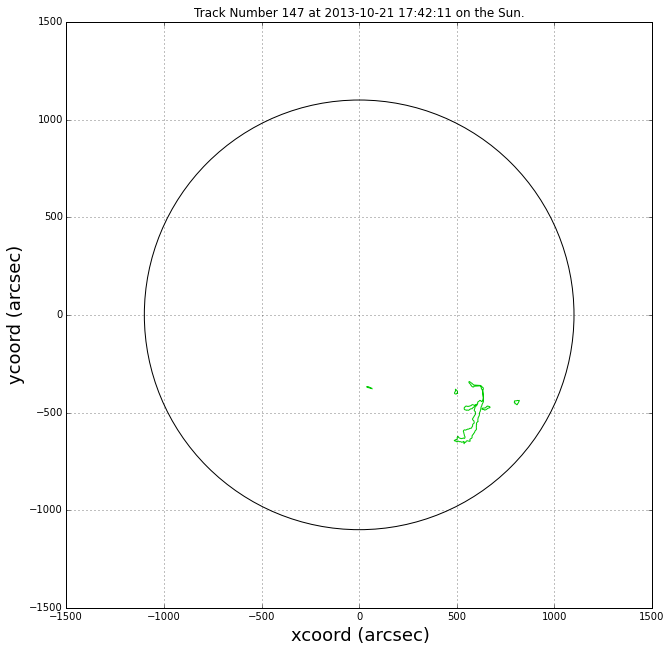


2013-10-17 18:00:16
2013-10-18 18:17:23
2013-10-19 17:21:00
2013-10-20 08:22:09
2013-10-21 17:42:11
2013-10-22 18:40:15
2013-10-23 18:42:48
2013-10-24 18:08:06
2013-10-25 17:47:37
2013-10-26 17:52:06
2013-10-27 07:07:15
2013-10-28 07:43:35
2013-10-29 09:16:41


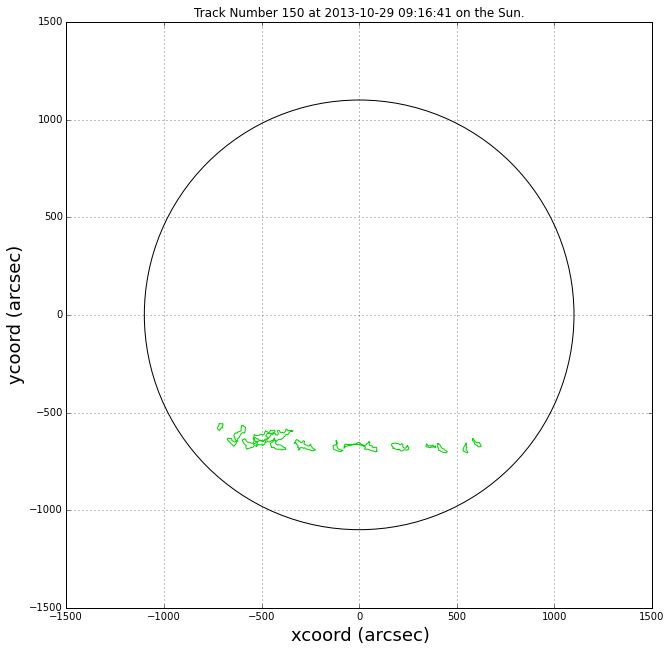


2013-10-19 17:21:00
2013-10-21 17:42:11
2013-10-22 18:40:15
2013-10-23 18:42:48
2013-10-24 18:08:06
2013-10-25 17:47:37


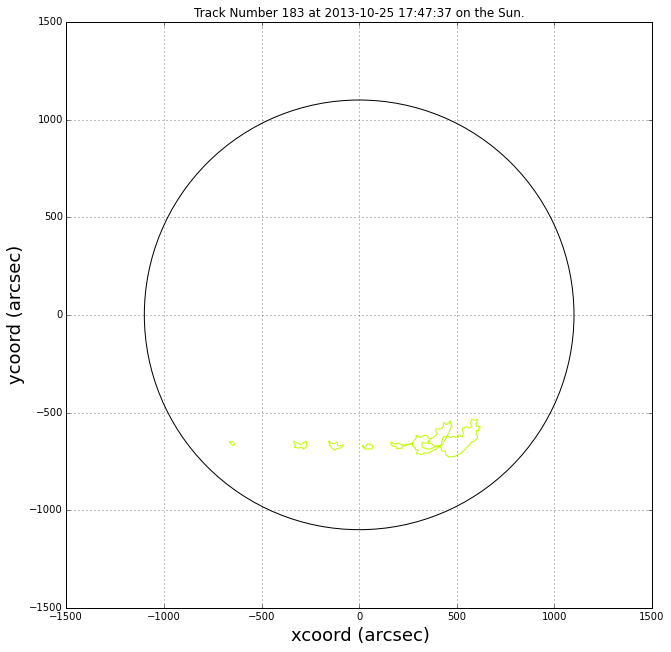


2013-10-20 08:22:09
2013-10-21 17:42:11
2013-10-22 18:40:15
2013-10-23 18:42:48
2013-10-25 17:47:37
2013-10-26 17:52:06
2013-10-28 07:43:35
2013-10-29 09:16:41


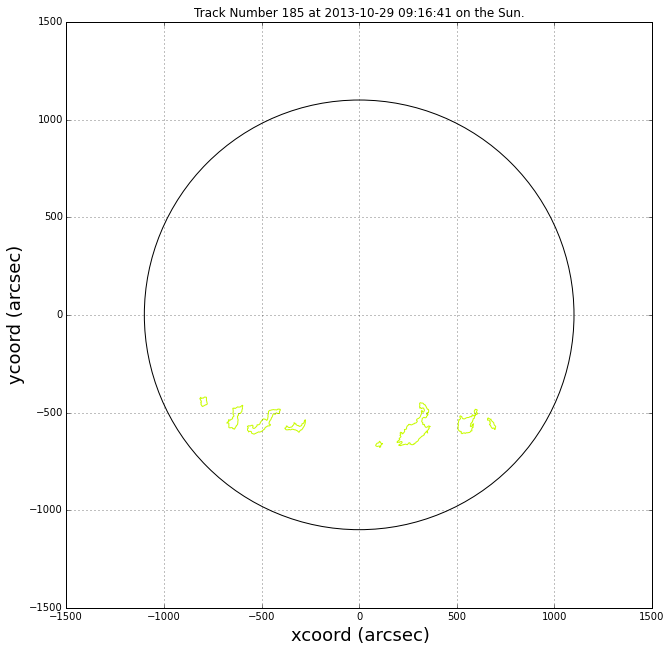


2013-10-21 17:42:11
2013-10-22 18:40:15
2013-10-24 18:08:06
2013-10-25 17:47:37
2013-10-26 17:52:06
2013-10-27 07:07:15


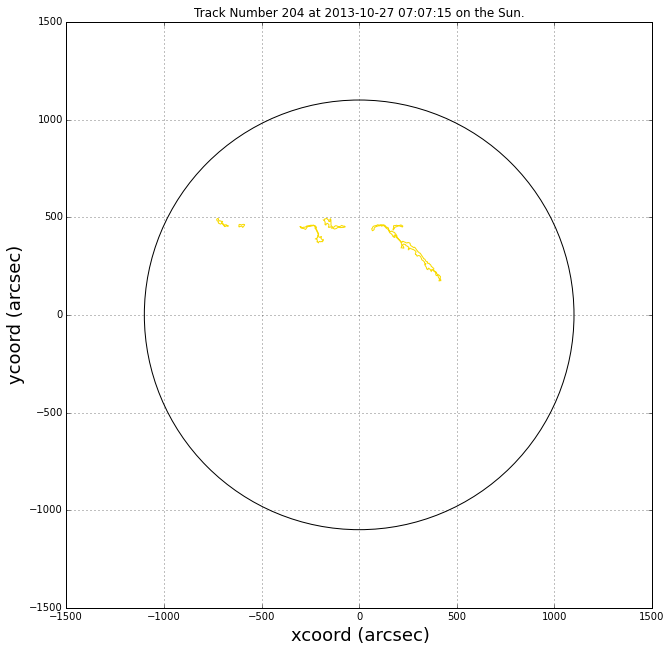


2013-10-21 17:42:11
2013-10-22 18:40:15
2013-10-23 18:42:48
2013-10-24 18:08:06
2013-10-25 17:47:37
2013-10-26 17:52:06


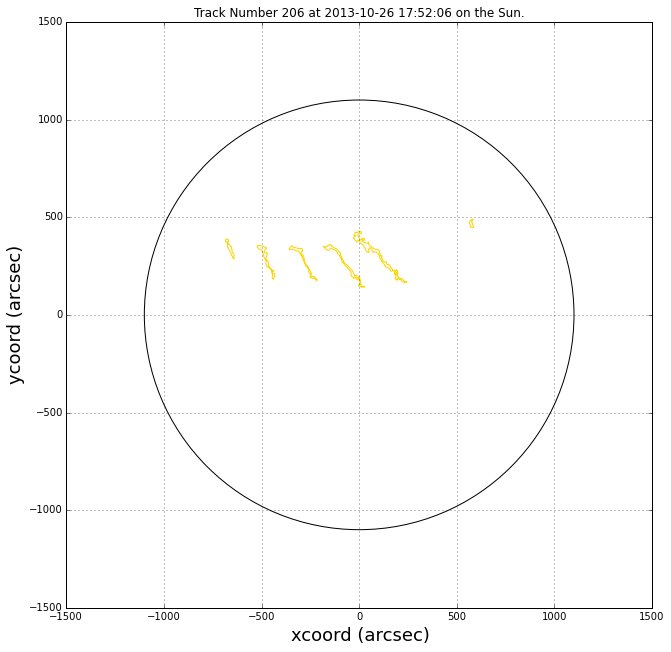


2013-10-21 17:42:11
2013-10-22 18:40:15
2013-10-24 18:08:06
2013-10-25 17:47:37
2013-10-26 17:52:06
2013-10-27 07:07:15
2013-10-28 07:43:35


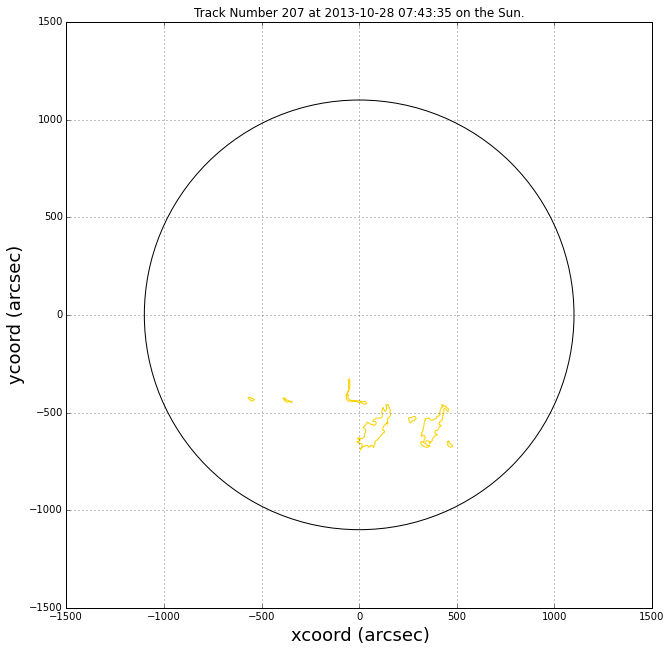


2013-10-22 18:40:15
2013-10-27 07:07:15
2013-10-28 07:43:35
2013-10-29 09:16:41
2013-10-30 17:29:23


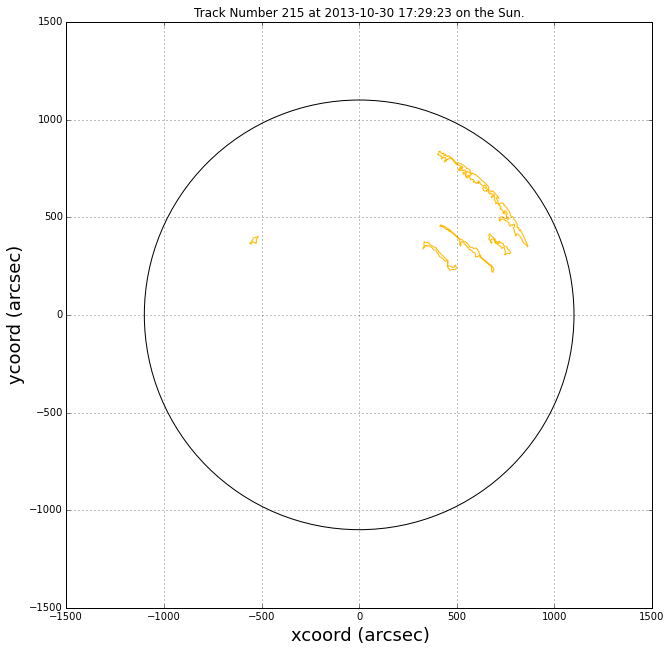


2013-10-22 18:40:15
2013-10-23 18:42:48
2013-10-24 18:08:06
2013-10-26 17:52:06


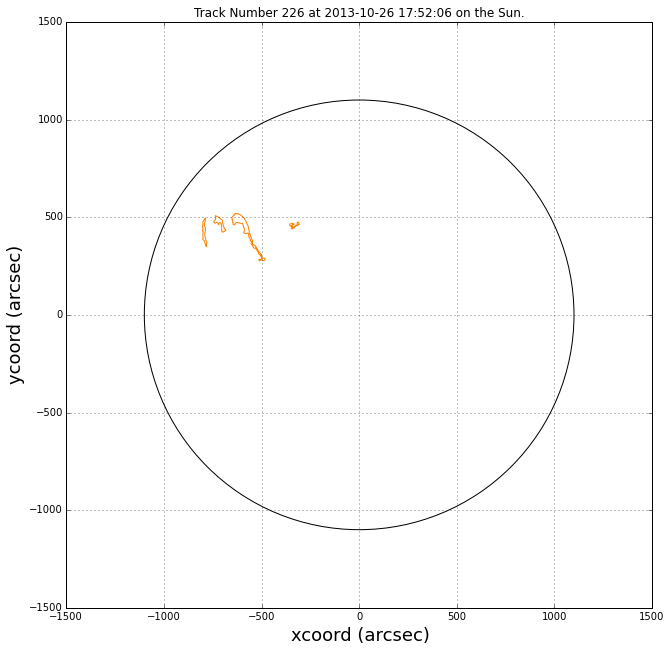

In [72]:
#######################
noerup=[]
erupind=[]
tot=[]
unique=[]
for tracks in big_track:
    tot.append(unique)
    unique=[]
    for i in range(0, len(good_tracks)):
        if tracks == good_tracks['Track No.'][i]:
            unique.append(i)

tot.pop(0)
for item in tot:
    colorscale2=[]
    norm = mpl.colors.Normalize(vmin=0, vmax=280)
    cmap = plt.get_cmap('nipy_spectral')
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for thing in close: #plotting those filaments that have eruptions contained within them
        scaleR= m.to_rgba(thing) 
        colorscale2.append(scaleR)
    
####plots eruptions/sun
    plt.grid(True)
    plt.ylabel('ycoord (arcsec)',fontsize=18)
    plt.xlabel('xcoord (arcsec)',fontsize=18)
    plt.axis([-1500, 1500, -1500, 1500])
    filtered4=[eruptions[i] for i in erupind]
    longitude = [elem["hpc_x"]for elem in noerup]
    latitude = [elem["hpc_y"] for elem in noerup]
    fig=plt.scatter(longitude,latitude, c = colorscale2,s=50)
    Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
    plt.gcf().gca().add_artist(Sun)
    #plt.title('Track (%s) on the Sun October 2013', )
    fig1 = plt.gcf()
    fig1.set_size_inches(10.5,10.5)
    ax = fig1.add_subplot(111)
    ax.set_aspect('equal')
    erupind=[]
    print ''
    for i in range(0, len(item)):
        j=item[i]
        trnum=  good_tracks['Track No.'][j]
        stime=  good_tracks['HEK_time'][j]
        print stime
        scale2=m.to_rgba(good_tracks['Track No.'][j])
        plot_polygon=plt.Polygon(loads(good_tracks['HPC_BB_Poly'][j]).exterior,color=scale2,linewidth=1,fill=None)
        fig1.gca().add_artist(plot_polygon)
        plt.title('Track Number %(Trackno)d at %(starttime)s on the Sun.' % {"Trackno" : trnum, "starttime": stime})
    plt.show()
            